In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
import dateutil.parser
import statsmodels.api as sm
import seaborn as sns
from datetime import date
from datetime import datetime
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [3]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

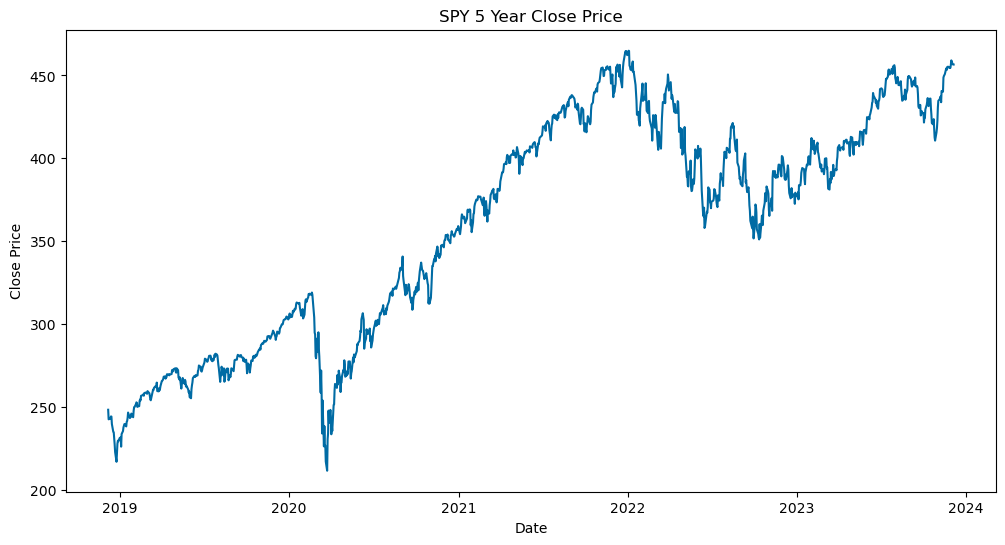

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

In [5]:
close

Date
2018-12-06 00:00:00-05:00    248.234100
2018-12-07 00:00:00-05:00    242.466141
2018-12-10 00:00:00-05:00    242.926117
2018-12-11 00:00:00-05:00    242.981293
2018-12-12 00:00:00-05:00    244.204834
                                ...    
2023-11-30 00:00:00-05:00    456.399994
2023-12-01 00:00:00-05:00    459.100006
2023-12-04 00:00:00-05:00    456.690002
2023-12-05 00:00:00-05:00    456.600006
2023-12-06 00:00:00-05:00    456.584991
Name: Close, Length: 1259, dtype: float64

## Check stationarity

### Split Price into halves for statistical analysis

In [6]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=303.280918, mean2=415.985578, mean_percent_diff=37.161804
variance1=2172.481543, variance2=703.603739, var_percent_diff=-67.612901


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [7]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.512943
p-value: 0.527099
Critical Values:
{'1%': -3.4355964295197743, '5%': -2.863856825923603, '10%': -2.5680035060041626}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [8]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.695144723071834, 0.01, 21, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.70
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


##### P-value < .05; therefore, not stationary

### Transform into stationary series

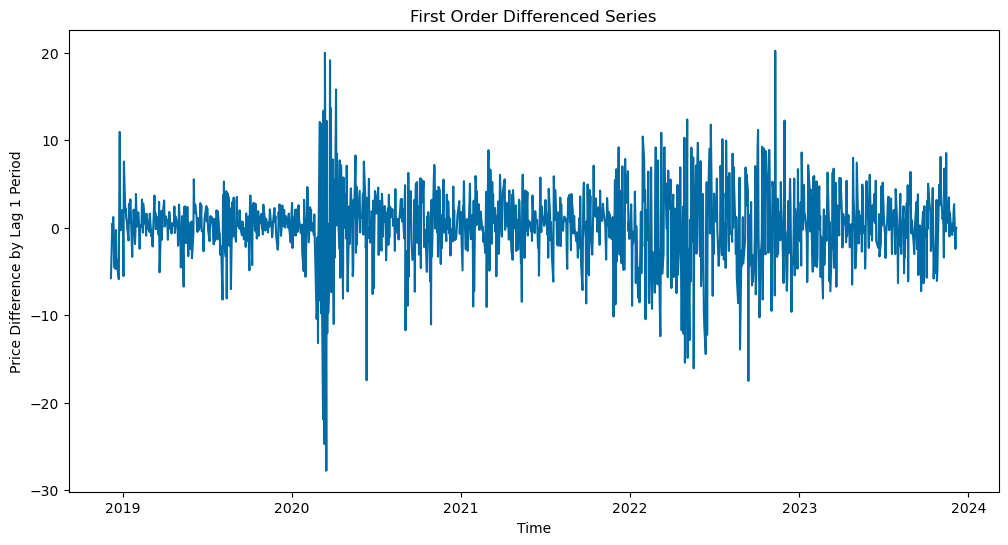

In [9]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14)
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [10]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -10.981745
p-value: 0.000000
Critical Values:
{'1%': -3.4355964295197743, '5%': -2.863856825923603, '10%': -2.5680035060041626}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [11]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [12]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [13]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: ADS506 - Module 1 and https://www.statsmodels.org/stable/tsa.html

In [14]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
print('AIC = %s' %(ses_model.aic))
print('BIC = %s' %(ses_model.bic))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

AIC = 3054.0330556031668
BIC = 3063.862517388604
Time Series Evaluation Metrics
MSE = 1194.649677130563
MAE = 28.449872989954883
RMSE = 34.563704621040884
MAPE = 0.06558388873339675
r2 = -1.168803054530188



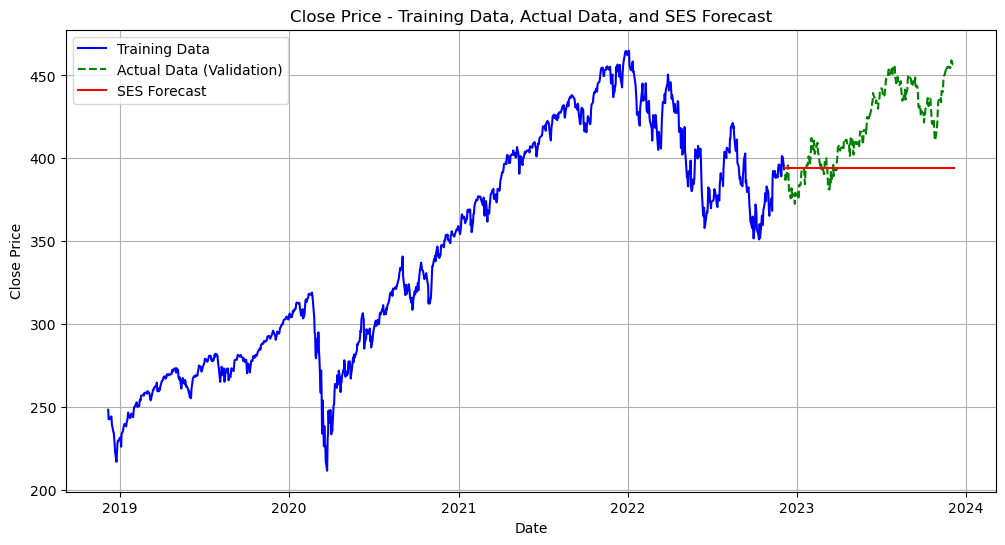

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

Simple Exponential Smoothing RMSE is 34.56% and it is higher to our success rate criteria. The forecast also doesn't include trend, seasonality and noise

In [16]:
# #impute to decompose
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

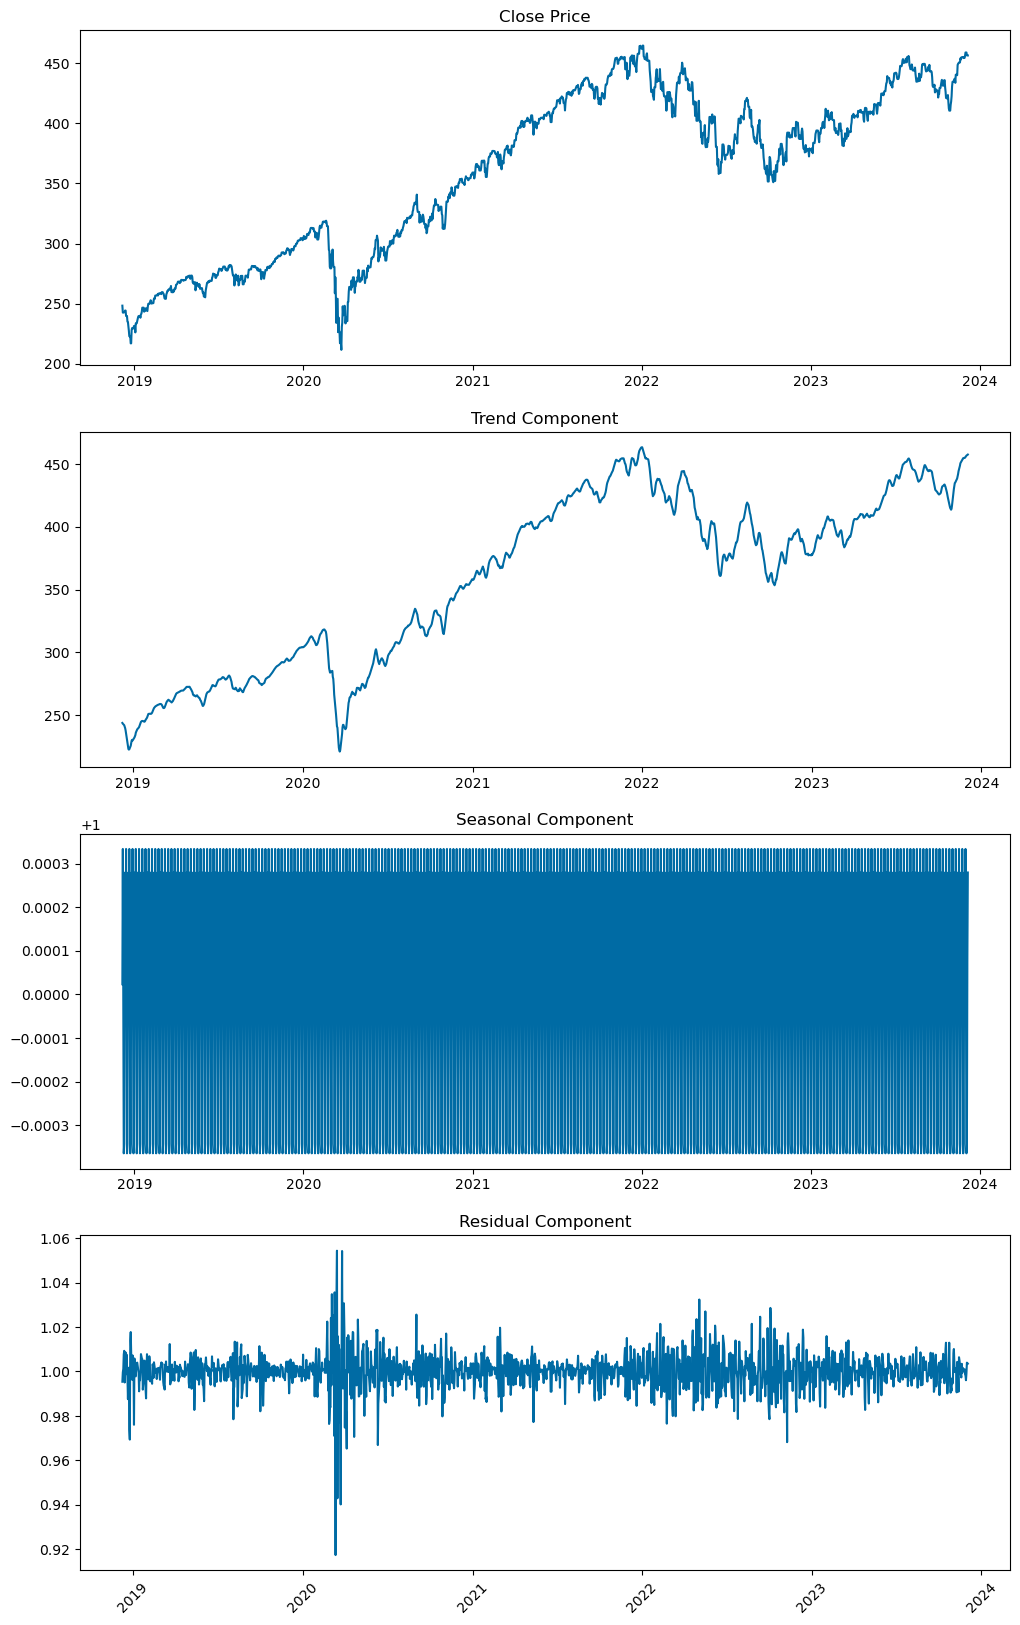

In [17]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

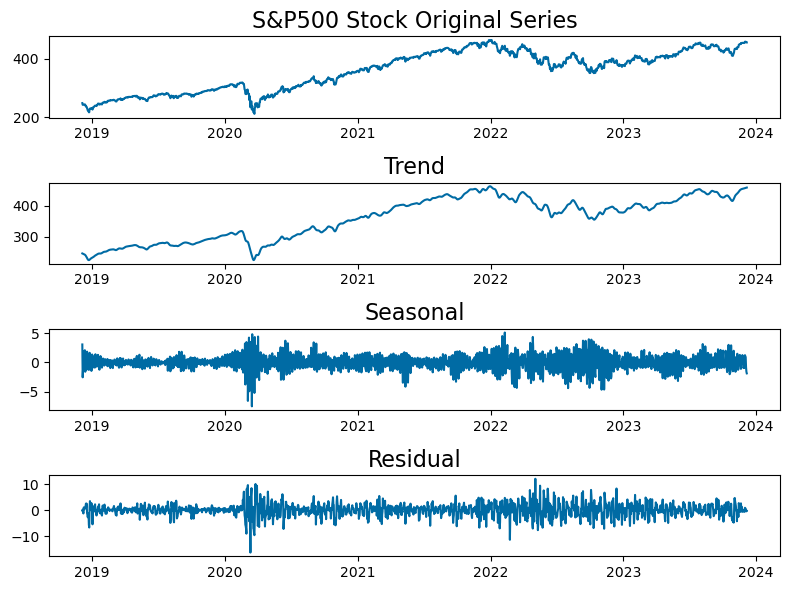

In [18]:
stl_close = STL(close)
stl_close_f = stl_close.fit()


# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(close)
plt.title('S&P500 Stock Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(stl_close_f.trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(stl_close_f.seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(stl_close_f.resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

Seasonal-Trend decomposition using LOESS (STL) shows a positive trend on SPY and seasonal around quarterly basis

### Anomaly Detection from STL Decomposition

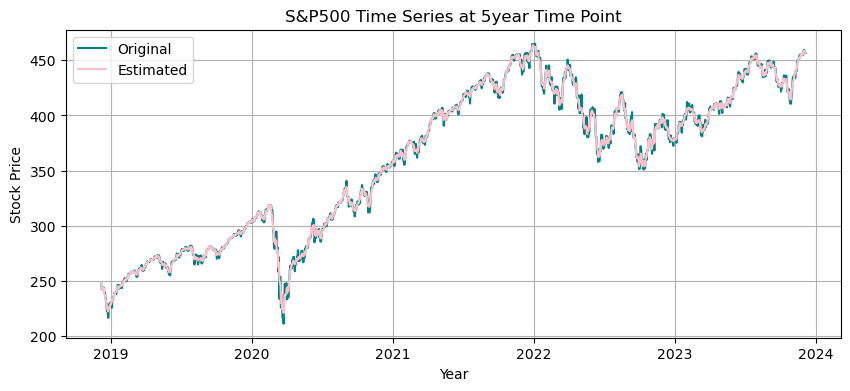

In [19]:
estimated0 = stl_close_f.trend + stl_close_f.seasonal
plt.figure(figsize=(10,4))
plt.plot(close, label='Original', color = 'teal')
plt.plot(estimated0, label ='Estimated', color = 'pink')


plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('S&P500 Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Taking residuals and detecting anomaly at 3std. dev:

resid_mu0 = stl_close_f.resid.mean()
resid_dev0 = stl_close_f.resid.std()

lower0 = resid_mu0 - 3*resid_dev0
upper0 = resid_mu0 + 3*resid_dev0

Text(0.5, 1.0, 'S&P500 at 5year Time Point')

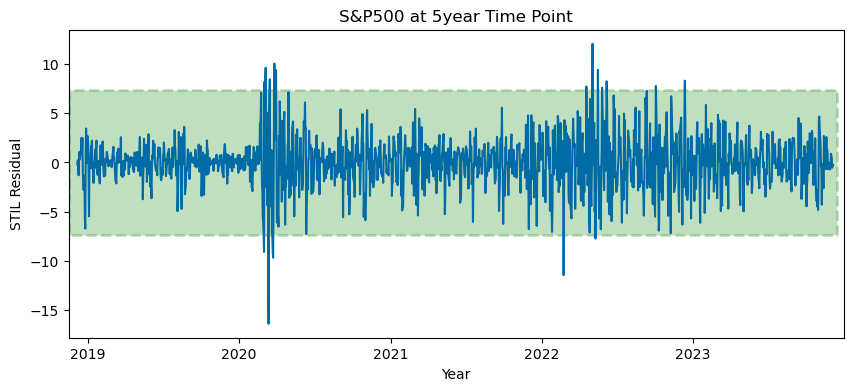

In [21]:
# Plot residual threshold:

plt.figure(figsize=(10,4))
plt.plot(stl_close_f.resid)

plt.fill_between([datetime(2018,11,15), datetime(2023,12,15)], lower0, upper0, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,11,15), datetime(2024,1,1))

plt.xlabel('Year')
plt.ylabel('STIL Residual')
plt.title('S&P500 at 5year Time Point')

In [22]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies0 = close[(stl_close_f.resid < lower0) | (stl_close_f.resid > upper0)]
anomalies0 = pd.DataFrame(anomalies0)

Text(0.5, 1.0, 'S&P500: Anomalies Marked at 3 Std. Dev or 99.7% within Normal Distribution ')

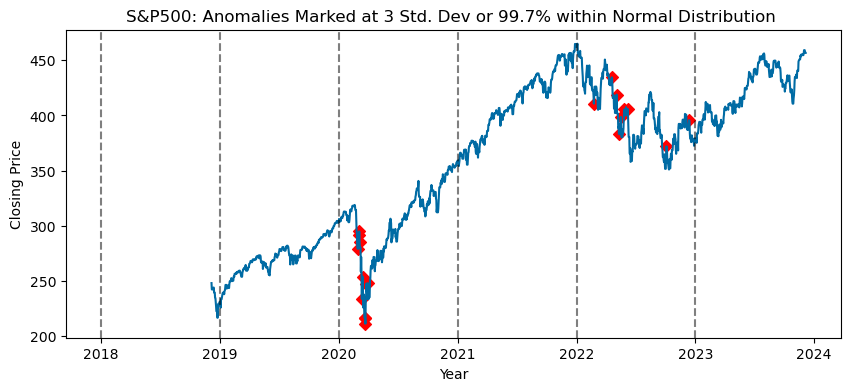

In [23]:
# Plot identified residual anomalies:

plt.figure(figsize=(10,4))
plt.plot(close)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

plt.scatter(anomalies0.index, anomalies0.Close, color='r', marker='D')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('S&P500: Anomalies Marked at 3 Std. Dev or 99.7% within Normal Distribution ')

In [24]:
# Anomalies identified outside 3std dev of residuals:

anomalies0.head()

,Close
Date,
2020-03-01 00:00:00-05:00,279.321075
2020-03-02 00:00:00-05:00,291.417511
2020-03-04 00:00:00-05:00,294.971954
2020-03-05 00:00:00-05:00,285.166595
2020-03-12 00:00:00-04:00,233.924088


### Gather parameters from decomposition

In [25]:
stl_close.config, stl_close.period

({'period': 7,
  'seasonal': 7,
  'seasonal_deg': 1,
  'seasonal_jump': 1,
  'trend': 15,
  'trend_deg': 1,
  'trend_jump': 1,
  'low_pass': 9,
  'low_pass_deg': 1,
  'low_pass_jump': 1,
  'robust': False},
 7)

## TO DO
### 1. Fit models to TREND and SEASON components
### 2. Make predictions with steps=len(close_valid) for each
### 3. Add these predictions to ARIMA predictions for FINAL prediction (sum of all components)

In [26]:
# Trend model for trend time series 'trend' from Blk 16 above
# <code here>

# Season model for seasonal time series 'seasonal' from Blk 16 above
# <code here>

# Make predictions for each to be added to the ARIMA residual predictions
# <code here>

### Autocorrelation - Raw Values
#### References: https://www.statsmodels.org/devel/graphics.html#time-series-plots

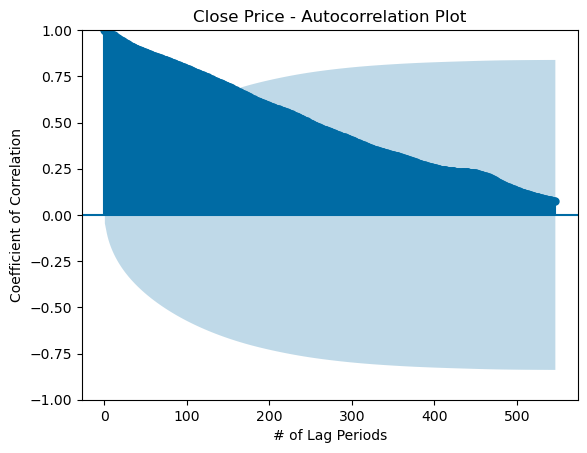

In [27]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

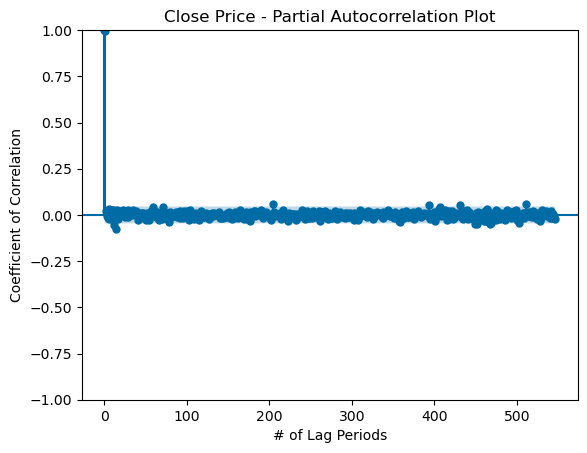

In [28]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

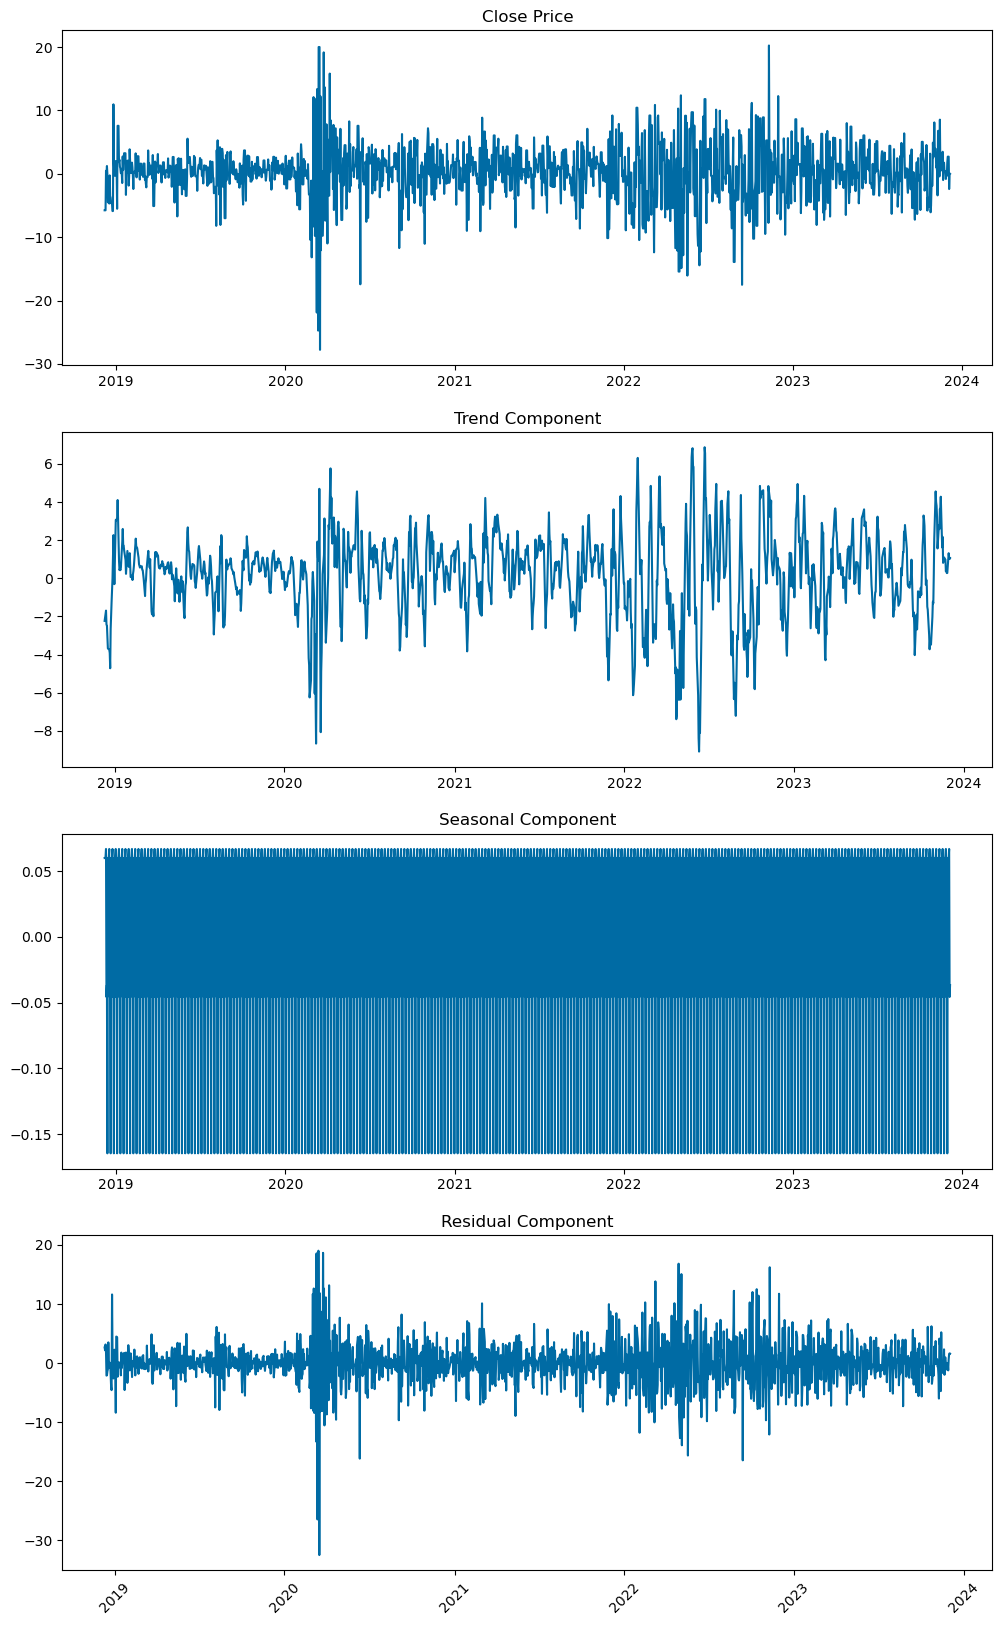

In [29]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

### Decompose using STL

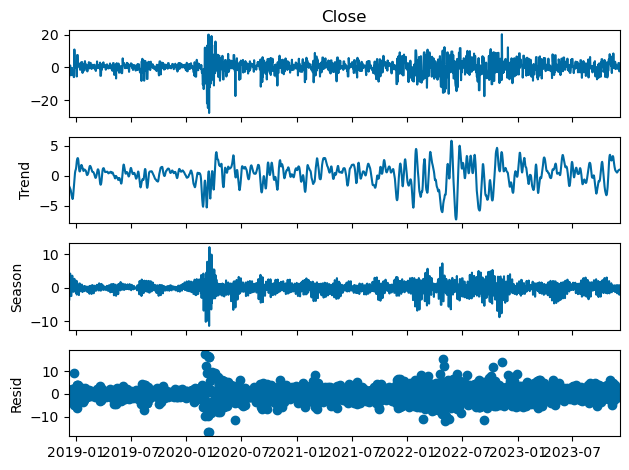

In [30]:
stl = STL(ts_lag_1)
stl_plot = stl.fit().plot()

In [31]:
stl.config, stl.period

({'period': 7,
  'seasonal': 7,
  'seasonal_deg': 1,
  'seasonal_jump': 1,
  'trend': 15,
  'trend_deg': 1,
  'trend_jump': 1,
  'low_pass': 9,
  'low_pass_deg': 1,
  'low_pass_jump': 1,
  'robust': False},
 7)

# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29 and 

### ACF on lag_1 period

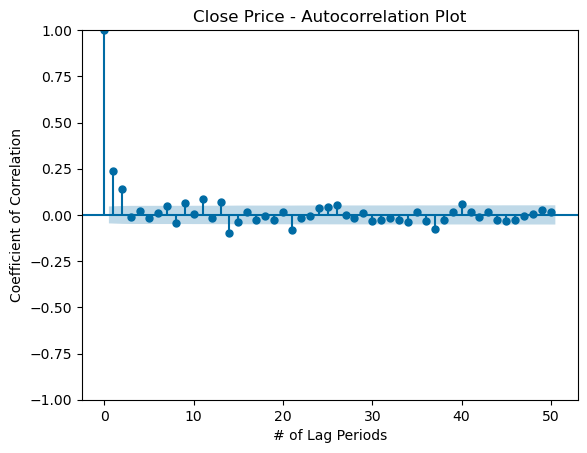

In [32]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we see a positive pattern in the quarterly basis. We may want to do MA at 0, 1, 2, 11, 13, 14, 21, 37, 40.

### Plot PACF on lag_1 period

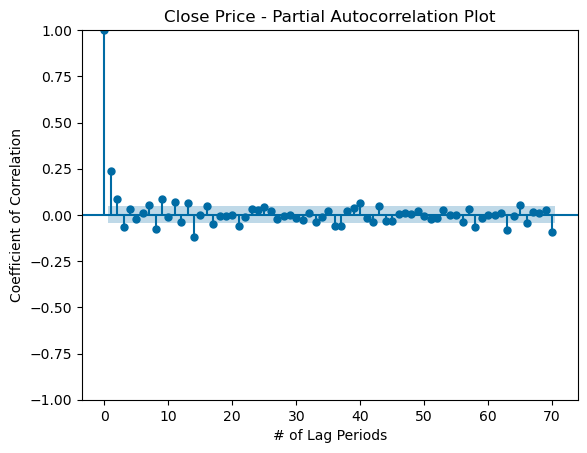

In [33]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

#### Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube].
#### https://www.youtube.com/watch?v=McEN54l3EPU
#### Finding AR_orders code would take a small of time

In [34]:
ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')


AIC for AR(1): 10448.988659822286
BIC for AR(1): 10465.516665620335


AIC for AR(2): 10437.166900739263
BIC for AR(2): 10459.204241803329


AIC for AR(3): 10431.345789866846
BIC for AR(3): 10458.892466196929


AIC for AR(8): 10422.932695567571
BIC for AR(8): 10478.026048227737


AIC for AR(9): 10411.171733750383
BIC for AR(9): 10471.774421676566


AIC for AR(11): 10406.010955724207
BIC for AR(11): 10477.632314182423


AIC for AR(14): 10375.083125670148
BIC for AR(14): 10463.232489926413


AIC for AR(21): 10373.53006819429
BIC for AR(21): 10500.244779312672




### The lower AIC and BIC is the better model selection; AR(14) has the lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

#### Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube].
#### https://www.youtube.com/watch?v=McEN54l3EPU
#### Finding AR_orders code (q) would take some time

In [35]:
#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [0, 1, 2, 11, 13, 14, 21, 37, 40] #actually MA orders, but using same var name for simplicity
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')


AIC for MA(0): 10479.739528463262
BIC for MA(0): 10562.37955745351


AIC for MA(1): 10375.083125670148
BIC for MA(1): 10463.232489926413


AIC for MA(2): 10405.032829737793
BIC for MA(2): 10498.691529260075


AIC for MA(11): 10367.363183195532
BIC for MA(11): 10510.605900111963


AIC for MA(13): 10370.255371059851
BIC for MA(13): 10524.516758508316


AIC for MA(14): 10367.097781376055
BIC for MA(14): 10526.868504090537


AIC for MA(21): 10371.160573202684
BIC for MA(21): 10569.49664277928


AIC for MA(37): 10359.081423154503
BIC for MA(37): 10645.566856987365


AIC for MA(40): 10362.595216978385
BIC for MA(40): 10665.608656609298




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [36]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA
print('AIC = %s' %(arima_model.aic))
print('BIC = %s' %(arima_model.bic))
arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

AIC = 10375.083125670148
BIC = 10463.232489926413
Time Series Evaluation Metrics
MSE = 176329.5932999451
MAE = 419.2598504848564
RMSE = 419.91617413472545
MAPE = 0.9994949209162758
r2 = -319.11406178214



### Result: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

## Attempt: Find optimal AES model parameters

In [37]:
#close_train = pd.DataFrame(close_train)
#close_train.reset_index(inplace=True)

In [38]:
#close_train.index

In [39]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [40]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal Period 2
AIC = 3555.1152597250525
BIC = 3589.5183759740826
Time Series Evaluation Metrics
MSE = 905.3130330804286
MAE = 24.874493485804877
RMSE = 30.088420248999924
MAPE = 0.0575934111736331
r2 = -0.6435325845203725

Results for Seasonal Period 3
AIC = 3863.6716400102273
BIC = 3902.989487151976
Time Series Evaluation Metrics
MSE = 884.2271265369103
MAE = 24.569009500583608
RMSE = 29.735956795383434
MAPE = 0.056911099317876614
r2 = -0.6052525938297437

Results for Seasonal Period 8
AIC = 4440.163656240392
BIC = 4504.055157845733
Time Series Evaluation Metrics
MSE = 1981.5352429777192
MAE = 42.50609560853374
RMSE = 44.51443858994202
MAPE = 0.10181614129406011
r2 = -2.597338843259585

Results for Seasonal Period 9
AIC = 4456.630808374545
BIC = 4525.437040872605
Time Series Evaluation Metrics
MSE = 2549.4957622844313
MAE = 48.38877982219113
RMSE = 50.49253174762018
MAPE = 0.11560023730340328
r2 = -3.6284314997139893

Results for Seasonal Period 11
AIC = 4540.2624161279

### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [41]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3908.6386486951546
BIC = 3943.0417649441847
Time Series Evaluation Metrics
MSE = 2708.6558719510886
MAE = 46.50034954922531
RMSE = 52.04474874520088
MAPE = 0.10983261411199498
r2 = -3.917375563076157

Results for Seasonal mul
AIC = 3907.668320385053
BIC = 3942.071436634083
Time Series Evaluation Metrics
MSE = 3028.118721586455
MAE = 49.202993124939155
RMSE = 55.02834471058034
MAPE = 0.11612223883552762
r2 = -4.497338055312598

Results for Seasonal additive
AIC = 3908.6386486951546
BIC = 3943.0417649441847
Time Series Evaluation Metrics
MSE = 2708.6558719510886
MAE = 46.50034954922531
RMSE = 52.04474874520088
MAPE = 0.10983261411199498
r2 = -3.917375563076157

Results for Seasonal multiplicative
AIC = 3907.668320385053
BIC = 3942.071436634083
Time Series Evaluation Metrics
MSE = 3028.118721586455
MAE = 49.202993124939155
RMSE = 55.02834471058034
MAPE = 0.11612223883552762
r2 = -4.497338055312598

Results for Seasonal None
AIC = 4649.141456358141
BIC = 4668

### Validation statistics suggest additive seasonality is optimal where it has the lowest RMSE

### Searching for ideal trend parameter

In [42]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train,
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     #damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Trend add
AIC = 3914.1568823741873
BIC = 3948.5599986232173
Time Series Evaluation Metrics
MSE = 1604.1338432010577
MAE = 36.335027581049715
RMSE = 40.05163970677178
MAPE = 0.08639154928601007
r2 = -1.9121929596683591

Results for Trend mul
AIC = 3908.6391001001966
BIC = 3943.0422163492267
Time Series Evaluation Metrics
MSE = 2708.6597369007163
MAE = 46.50037833541788
RMSE = 52.04478587621162
MAPE = 0.10983267956845366
r2 = -3.917382579622278

Results for Trend additive
AIC = 3914.1568823741873
BIC = 3948.5599986232173
Time Series Evaluation Metrics
MSE = 1604.1338432010577
MAE = 36.335027581049715
RMSE = 40.05163970677178
MAPE = 0.08639154928601007
r2 = -1.9121929596683591

Results for Trend multiplicative
AIC = 3908.6391001001966
BIC = 3943.0422163492267
Time Series Evaluation Metrics
MSE = 2708.6597369007163
MAE = 46.50037833541788
RMSE = 52.04478587621162
MAPE = 0.10983267956845366
r2 = -3.917382579622278

Results for Trend None
AIC = 3881.7843756968955
BIC = 3906.35803

### Validation statistics suggest multiplicative trend is optimal. ????????? RAVITA -  Although SPY STL decomposition shows a positive trend, Exponential Smoothing Model suggest to use Trend None parameter. It has the lowest RMSE and smaller AIC/ BIC. Since the damped is True, Trend should not be None

### Searching for ideal aes_param_damped_trend parameter

In [43]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3898.274858923537
BIC = 3937.5927060652857
Time Series Evaluation Metrics
MSE = 331.59441606591224
MAE = 15.474493338918718
RMSE = 18.209734102010174
MAPE = 0.03798483006268253
r2 = 0.3980134961771664

Results for Damped Trend False
AIC = 3908.6386339205233
BIC = 3943.0417501695533
Time Series Evaluation Metrics
MSE = 2708.657385049508
MAE = 46.50036208584223
RMSE = 52.044763281712676
MAPE = 0.10983264308499868
r2 = -3.917378310000662



### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [44]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Initialization Method None
AIC = 3902.922292910867
BIC = 3937.325409159897
Time Series Evaluation Metrics
MSE = 1624.3158760127374
MAE = 36.56463498961334
RMSE = 40.30280233448708
MAPE = 0.086923494445778
r2 = -1.948832030725351

Results for Initialization Method estimated
AIC = 3902.671140003017
BIC = 3937.0742562520472
Time Series Evaluation Metrics
MSE = 1624.5237544734582
MAE = 36.56699154518059
RMSE = 40.30538120987641
MAPE = 0.08692895416689901
r2 = -1.949209419552564

Results for Initialization Method heuristic
AIC = 3914.1566708062287
BIC = 3948.5597870552588
Time Series Evaluation Metrics
MSE = 1604.130473047786
MAE = 36.334990207918146
RMSE = 40.0515976341492
MAPE = 0.08639146316812112
r2 = -1.9121868413904655

Results for Initialization Method legacy-heuristic
AIC = 3902.922292910867
BIC = 3937.325409159897
Time Series Evaluation Metrics
MSE = 1624.3158760127374
MAE = 36.56463498961334
RMSE = 40.30280233448708
MAPE = 0.086923494445778
r2 = -1.948832030725351



### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [46]:
aes_model = ExponentialSmoothing(close_train,
                                 trend= 'mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3,
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1,
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3897.7799370608554
BIC = 3937.097784202604
Time Series Evaluation Metrics
MSE = 372.7010103775585
MAE = 16.19043094884262
RMSE = 19.305465816124677
MAPE = 0.03983846816864742
r2 = 0.32338734508778044

None


### AES model takes a while to run

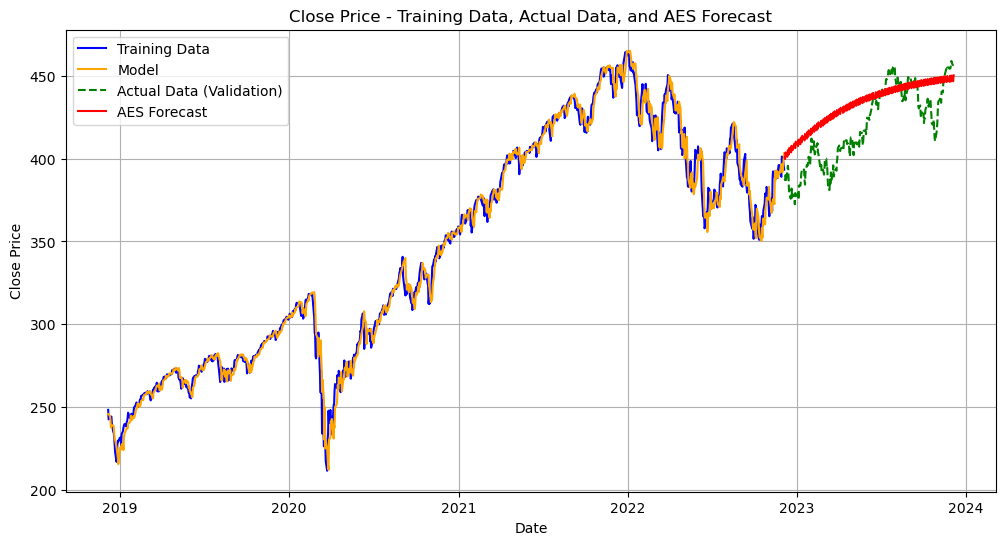

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [48]:
aes_model = ExponentialSmoothing(close_train,
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2,
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1,
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3574.7682218441946
BIC = 3609.1713380932247
Time Series Evaluation Metrics
MSE = 324.1639305405525
MAE = 15.543746190958693
RMSE = 18.00455305028571
MAPE = 0.03696583728975805
r2 = 0.41150302370355385

None


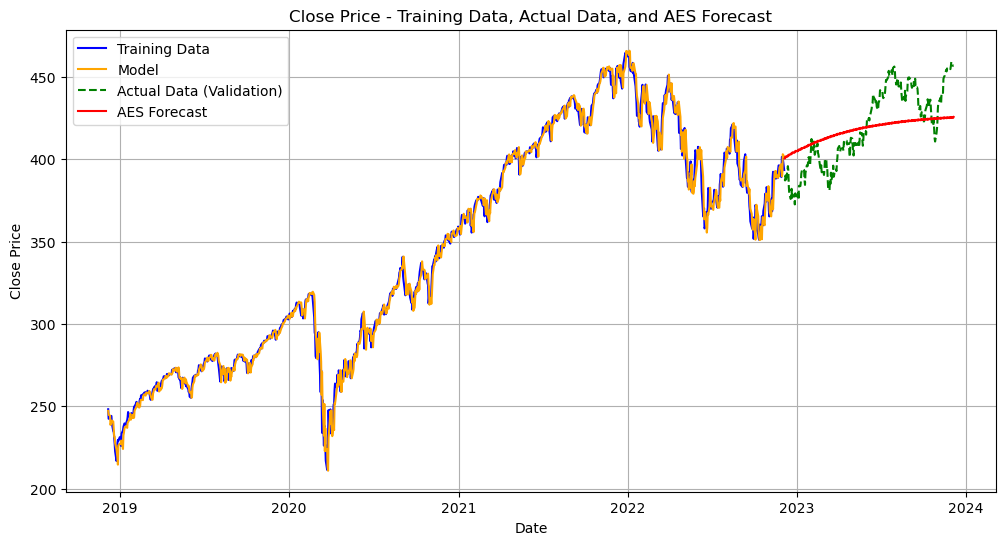

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

#####  https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [50]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,1)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# TO DO: ADD TREND AND SEASONAL FORECASTS TO ARIMA FORECAST (RESIDUAL COMPONENT) FOR FINAL FORECAST

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1461
Model:                ARIMA(14, 1, 1)   Log Likelihood               -2946.091
Date:                Wed, 06 Dec 2023   AIC                           5924.182
Time:                        09:18:11   BIC                           6008.761
Sample:                    12-06-2018   HQIC                          5955.733
                         - 12-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0334      1.116     -0.030      0.976      -2.221       2.154
ar.L2         -0.0984      0.156     -0.630      0.529      -0.405       0.208
ar.L3          0.1955      0.124      1.580      0.1

In [51]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

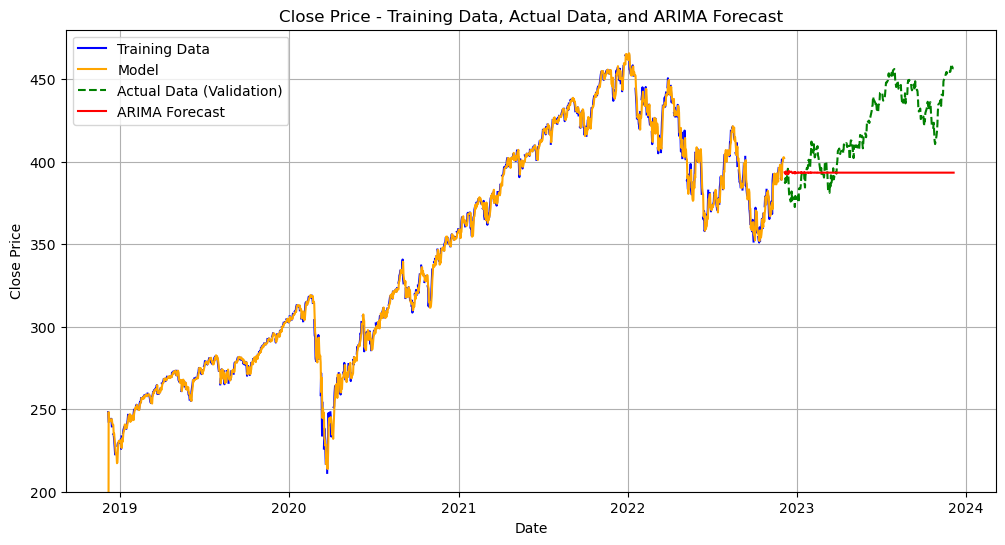

In [52]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression Model on SPY

### Add fields on open-close difference

In [53]:
hist = aapl.history(period = '1y')
# # hist = hist.diff()
# hist = hist.diff(periods=15)
# hist = hist.shift(3)
# hist = hist.dropna()
# hist['open_close'] = hist['Close'] - hist['Open']
# hist['positive'] = np.where(hist['open_close'] >= 0, 1, 0)
# hist['high_low'] = hist['High'] - hist['Low']

# X = hist.drop(['positive'], axis =1)
# y = hist['positive']

# Add columns
hist['open_close'] = hist['Close'] - hist['Open']
hist['positive'] = np.where(hist['open_close'] > 0, 1, 0)
hist['high_low'] = hist['High'] - hist['Low']
hist = hist.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1) # Clean out sparse columns
hist.head()

,Open,High,Low,Close,Volume,open_close,positive,high_low
Date,,,,,,,,
2022-12-06 00:00:00-05:00,393.229710,393.790853,385.570287,387.726318,77972200,-5.503391,0,8.220566
2022-12-07 00:00:00-05:00,386.850120,389.508287,385.895152,387.066711,65927900,0.216592,1,3.613135
2022-12-08 00:00:00-05:00,389.016041,391.201606,387.174997,390.098969,60737900,1.082928,1,4.026609
2022-12-09 00:00:00-05:00,388.819121,391.457579,387.056855,387.184845,81447700,-1.634277,0,4.400724
2022-12-12 00:00:00-05:00,388.001983,392.766998,387.312850,392.766998,75405800,4.765015,1,5.454148


In [54]:
spy_desc = hist.copy()
spy_desc['Date'] = pd.to_datetime(spy_desc.index)
spy_desc.insert(0, 'day_of_week', spy_desc['Date'].dt.day_name())
spy_desc.head()

,day_of_week,Open,High,Low,Close,Volume,open_close,positive,high_low,Date
Date,,,,,,,,,,
2022-12-06 00:00:00-05:00,Tuesday,393.229710,393.790853,385.570287,387.726318,77972200,-5.503391,0,8.220566,2022-12-06 00:00:00-05:00
2022-12-07 00:00:00-05:00,Wednesday,386.850120,389.508287,385.895152,387.066711,65927900,0.216592,1,3.613135,2022-12-07 00:00:00-05:00
2022-12-08 00:00:00-05:00,Thursday,389.016041,391.201606,387.174997,390.098969,60737900,1.082928,1,4.026609,2022-12-08 00:00:00-05:00
2022-12-09 00:00:00-05:00,Friday,388.819121,391.457579,387.056855,387.184845,81447700,-1.634277,0,4.400724,2022-12-09 00:00:00-05:00
2022-12-12 00:00:00-05:00,Monday,388.001983,392.766998,387.312850,392.766998,75405800,4.765015,1,5.454148,2022-12-12 00:00:00-05:00


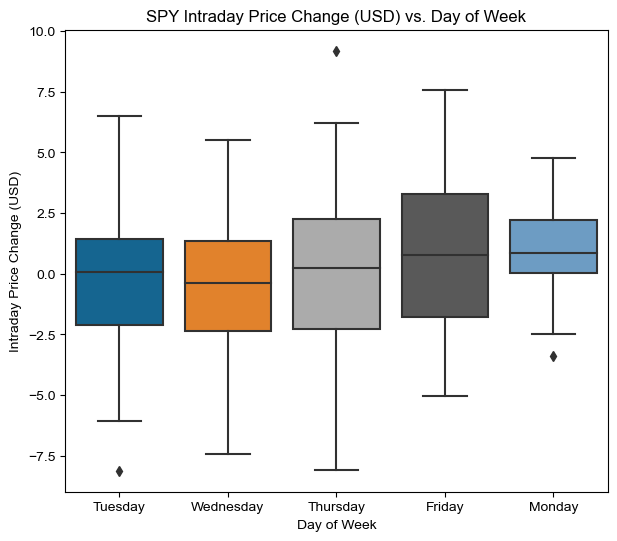

In [55]:
# From Deniega (2023) ADS 505 Final Project
target_y = 'open_close'
column_x = 'day_of_week'

plt.figure(figsize=(7, 6))
sns.boxplot(x=column_x, y=target_y, data=spy_desc)
sns.set_style("whitegrid")
plt.title("SPY Intraday Price Change (USD) vs. Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Intraday Price Change (USD)")
plt.show()

In [56]:
day_week_stats = spy_desc.groupby('day_of_week').describe().transpose()
display(day_week_stats.loc['open_close'])

day_of_week,Friday,Monday,Thursday,Tuesday,Wednesday
count,51.000000,45.000000,51.000000,52.000000,53.000000
mean,0.683978,1.075894,-0.076981,-0.181028,-0.486583
std,3.129997,1.933707,3.717666,3.019553,2.827106
min,-5.024221,-3.412140,-8.090198,-8.122140,-7.437469
25%,-1.795289,0.039720,-2.288197,-2.109694,-2.343017
50%,0.751667,0.850006,0.239147,0.059998,-0.368725
75%,3.277120,2.220001,2.272510,1.417153,1.335317
max,7.570007,4.765015,9.187998,6.487128,5.528633


In [57]:
hist_lag = hist.copy()

lag = 3

hist_lag = hist_lag.diff(periods=lag)
#for lag in range(1, 6):
#    globals()[f'hist_lag_{lag}'] = hist_lag.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_lag[lag_col_name] = hist_lag[col].shift(i)

hist_lag = hist_lag.dropna()
#hist_lag_1 = hist_lag_1.dropna() # Remove missing values due to lags out of range
#hist_lag_2 = hist_lag_2.dropna()
#hist_lag_3 = hist_lag_3.dropna()
#hist_lag_4 = hist_lag_4.dropna()
#hist_lag_5 = hist_lag_5.dropna()

In [58]:
pd.set_option('display.max_columns', 70)
display(hist_lag.head())
#display(hist_lag_1.head())
#display(hist_lag_2.head())
#display(hist_lag_3.head())

,Open,High,Low,Close,Volume,open_close,positive,high_low,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,open_close_lag1,positive_lag1,high_low_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2,Volume_lag2,open_close_lag2,positive_lag2,high_low_lag2,Open_lag1_lag2,High_lag1_lag2,Low_lag1_lag2,Close_lag1_lag2,Volume_lag1_lag2,open_close_lag1_lag2,positive_lag1_lag2,high_low_lag1_lag2,Open_lag3,High_lag3,Low_lag3,Close_lag3,Volume_lag3,open_close_lag3,positive_lag3,high_low_lag3,Open_lag1_lag3,High_lag1_lag3,Low_lag1_lag3,Close_lag1_lag3,Volume_lag1_lag3,open_close_lag1_lag3,positive_lag1_lag3,high_low_lag1_lag3,Open_lag2_lag3,High_lag2_lag3,Low_lag2_lag3,Close_lag2_lag3,Volume_lag2_lag3,open_close_lag2_lag3,positive_lag2_lag3,high_low_lag2_lag3,Open_lag1_lag2_lag3,High_lag1_lag2_lag3,Low_lag1_lag2_lag3,Close_lag1_lag2_lag3,Volume_lag1_lag2_lag3,open_close_lag1_lag2_lag3,positive_lag1_lag2_lag3,high_low_lag1_lag2_lag3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-19 00:00:00-05:00,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,0.187023,-3.642703,-5.434473,-9.175598,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846272,12.926512,5.710127,5.641205,63044600.0,-9.205067,-1.0,7.216385,1.151863,3.258712,1.417698,5.700287,9477900.0,4.548423,0.0,1.841014,-4.410588,-2.333274,1.486568,-0.541473,3475500.0,3.869115,0.0,-3.819842
2022-12-20 00:00:00-05:00,-13.121983,-11.090204,-8.176209,-7.228760,-43278700.0,5.893223,1.0,-2.913995,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,0.187023,-3.642703,-5.434473,-9.175598,42300100.0,-9.362621,-1.0,1.791770,0.187023,-3.642703,-5.434473,-9.175598,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846272,12.926512,5.710127,5.641205,63044600.0,-9.205067,-1.0,7.216385,1.151863,3.258712,1.417698,5.700287,9477900.0,4.548423,0.0,1.841014
2022-12-21 00:00:00-05:00,-1.908784,0.820928,1.631904,2.927551,-41690600.0,4.836335,1.0,-0.810975,-13.121983,-11.090204,-8.176209,-7.228760,-43278700.0,5.893223,1.0,-2.913995,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,0.187023,-3.642703,-5.434473,-9.175598,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846272,12.926512,5.710127,5.641205,63044600.0,-9.205067,-1.0,7.216385
2022-12-22 00:00:00-05:00,-0.415378,2.363773,-3.471455,0.692352,20242800.0,1.107731,0.0,5.835228,-1.908784,0.820928,1.631904,2.927551,-41690600.0,4.836335,1.0,-0.810975,-13.121983,-11.090204,-8.176209,-7.228760,-43278700.0,5.893223,1.0,-2.913995,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,0.187023,-3.642703,-5.434473,-9.175598,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849
2022-12-23 00:00:00-05:00,0.415388,0.820891,0.178032,2.343994,-14569900.0,1.928606,0.0,0.642859,-0.415378,2.363773,-3.471455,0.692352,20242800.0,1.107731,0.0,5.835228,-1.908784,0.820928,1.631904,2.927551,-41690600.0,4.836335,1.0,-0.810975,-13.121983,-11.090204,-8.176209,-7.228760,-43278700.0,5.893223,1.0,-2.913995,-13.121983,-11.090204,-8.176209,-7.228760,-43278700.0,5.893223,1.0,-2.913995,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-22.910593,-21.791772,-16.027942,-16.67749

#### Reference: https://scikit-learn.org/

              precision    recall  f1-score   support

           0       0.50      0.71      0.59        14
           1       0.83      0.66      0.73        29

    accuracy                           0.67        43
   macro avg       0.66      0.68      0.66        43
weighted avg       0.72      0.67      0.68        43



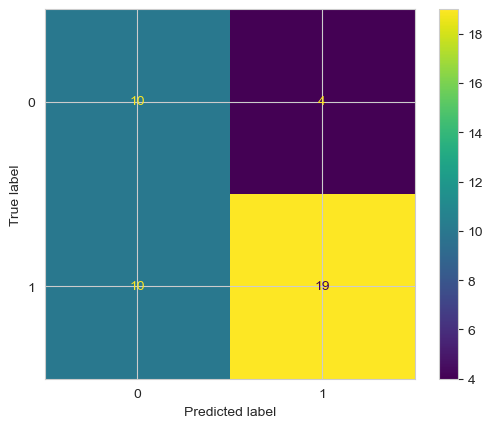

In [59]:
## Change n to lag the data
#for n in range(1, 6):

# Data partition
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_lag.drop(['positive'], axis=1)
y = y.reindex(X.index)

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


# Model and fitting
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

# Model Performance
logreg_pred = logreg_model.predict(X_valid)
logreg_pred = pd.Series(logreg_pred, index=X_valid.index)
y_valid = y_valid.reindex(logreg_pred.index)
cm = confusion_matrix(y_valid, logreg_pred, labels=logreg_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
cmd.plot()
print(classification_report(y_valid, logreg_pred))

Lag = 1
              precision    recall  f1-score   support

           0       0.50      0.71      0.59        14
           1       0.83      0.66      0.73        29

    accuracy                           0.67        43
   macro avg       0.66      0.68      0.66        43
weighted avg       0.72      0.67      0.68        43



Lag = 2
              precision    recall  f1-score   support

           0       0.50      0.71      0.59        14
           1       0.83      0.66      0.73        29

    accuracy                           0.67        43
   macro avg       0.66      0.68      0.66        43
weighted avg       0.72      0.67      0.68        43



Lag = 3
              precision    recall  f1-score   support

           0       0.50      0.71      0.59        14
           1       0.83      0.66      0.73        29

    accuracy                           0.67        43
   macro avg       0.66      0.68      0.66        43
weighted avg       0.72      0.67      0.68   

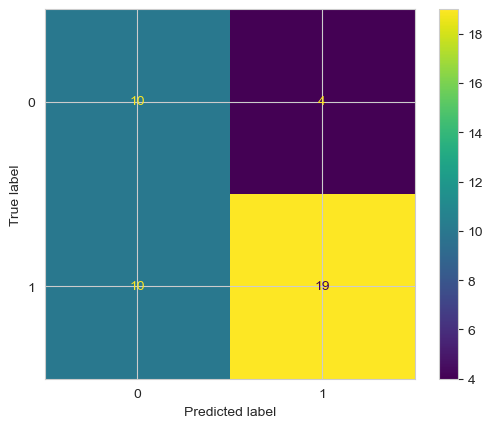

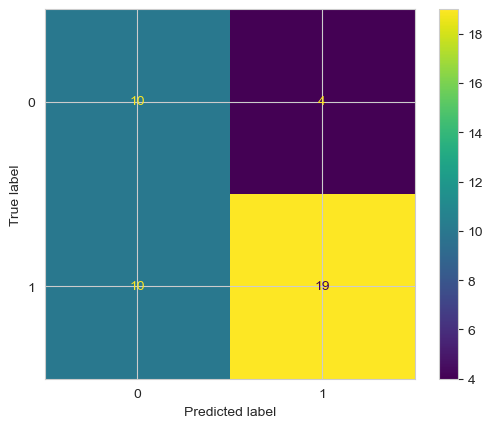

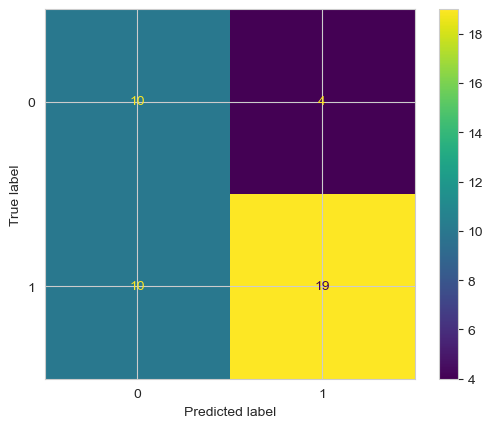

In [60]:
orders = [1,2,3] # hard-coded
log_fitted_model_dict = {}
logreg_pred_dict = {}
# Fit the models and instantiate each model individually
for i, order in enumerate(orders):
    logreg_model = LogisticRegression()
    logreg_model = logreg_model.fit(X_train,y_train)
    log_fitted_model_dict[order] = logreg_model
for order in orders:
    logreg_pred_dict[order] = log_fitted_model_dict[order].predict(X_valid)
    logreg_pred_dict[order] = pd.Series(logreg_pred_dict[order], index=X_valid.index)
    cm = confusion_matrix(y_valid, logreg_pred_dict[order], labels=logreg_model.classes_)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
    print('Lag = %s' %(order))
    cmd.plot()
    print(classification_report(y_valid, logreg_pred_dict[order]))
    print('\n')

# ????? Confusion matrix has the same result for all the lag

## Cross-sectional MLP (Neural Network) Model

Using cross-sectional since the dataframe that will be used already statically assigns the lagged values to its respective column. Shuffling across records does not dynamically change the values of the lagged columns.

### Make copy of historical data (differenced at lag=3)

In [61]:
hist_diff = hist.copy()
lag = 3
hist_diff = hist_diff.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_diff.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_diff[lag_col_name] = hist_diff[col].shift(i)

hist_diff = hist_diff.dropna() # Remove missing values due to lags out of range
hist_diff.head()

,Open,High,Low,Close,Volume,open_close,positive,high_low,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,open_close_lag1,positive_lag1,high_low_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2,Volume_lag2,open_close_lag2,positive_lag2,high_low_lag2,Open_lag1_lag2,High_lag1_lag2,Low_lag1_lag2,Close_lag1_lag2,Volume_lag1_lag2,open_close_lag1_lag2,positive_lag1_lag2,high_low_lag1_lag2,Open_lag3,High_lag3,Low_lag3,Close_lag3,Volume_lag3,open_close_lag3,positive_lag3,high_low_lag3,Open_lag1_lag3,High_lag1_lag3,Low_lag1_lag3,Close_lag1_lag3,Volume_lag1_lag3,open_close_lag1_lag3,positive_lag1_lag3,high_low_lag1_lag3,Open_lag2_lag3,High_lag2_lag3,Low_lag2_lag3,Close_lag2_lag3,Volume_lag2_lag3,open_close_lag2_lag3,positive_lag2_lag3,high_low_lag2_lag3,Open_lag1_lag2_lag3,High_lag1_lag2_lag3,Low_lag1_lag2_lag3,Close_lag1_lag2_lag3,Volume_lag1_lag2_lag3,open_close_lag1_lag2_lag3,positive_lag1_lag2_lag3,high_low_lag1_lag2_lag3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-19 00:00:00-05:00,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,0.187023,-3.642703,-5.434473,-9.175598,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846272,12.926512,5.710127,5.641205,63044600.0,-9.205067,-1.0,7.216385,1.151863,3.258712,1.417698,5.700287,9477900.0,4.548423,0.0,1.841014,-4.410588,-2.333274,1.486568,-0.541473,3475500.0,3.869115,0.0,-3.819842
2022-12-20 00:00:00-05:00,-13.121983,-11.090204,-8.176209,-7.228760,-43278700.0,5.893223,1.0,-2.913995,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,0.187023,-3.642703,-5.434473,-9.175598,42300100.0,-9.362621,-1.0,1.791770,0.187023,-3.642703,-5.434473,-9.175598,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846272,12.926512,5.710127,5.641205,63044600.0,-9.205067,-1.0,7.216385,1.151863,3.258712,1.417698,5.700287,9477900.0,4.548423,0.0,1.841014
2022-12-21 00:00:00-05:00,-1.908784,0.820928,1.631904,2.927551,-41690600.0,4.836335,1.0,-0.810975,-13.121983,-11.090204,-8.176209,-7.228760,-43278700.0,5.893223,1.0,-2.913995,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,0.187023,-3.642703,-5.434473,-9.175598,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846272,12.926512,5.710127,5.641205,63044600.0,-9.205067,-1.0,7.216385
2022-12-22 00:00:00-05:00,-0.415378,2.363773,-3.471455,0.692352,20242800.0,1.107731,0.0,5.835228,-1.908784,0.820928,1.631904,2.927551,-41690600.0,4.836335,1.0,-0.810975,-13.121983,-11.090204,-8.176209,-7.228760,-43278700.0,5.893223,1.0,-2.913995,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,0.187023,-3.642703,-5.434473,-9.175598,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849
2022-12-23 00:00:00-05:00,0.415388,0.820891,0.178032,2.343994,-14569900.0,1.928606,0.0,0.642859,-0.415378,2.363773,-3.471455,0.692352,20242800.0,1.107731,0.0,5.835228,-1.908784,0.820928,1.631904,2.927551,-41690600.0,4.836335,1.0,-0.810975,-13.121983,-11.090204,-8.176209,-7.228760,-43278700.0,5.893223,1.0,-2.913995,-13.121983,-11.090204,-8.176209,-7.228760,-43278700.0,5.893223,1.0,-2.913995,-16.125234,-19.608796,-16.040416,-17.361633,-28233200.0,-1.236400,0.0,-3.568380,-22.910593,-21.791772,-16.027942,-16.67749

### Preprocess dataframes for RobustScaler due to expected outlier stock price movements

In [62]:
hist_diff_scale = RobustScaler().fit_transform(hist_diff)
hist_diff_scale = pd.DataFrame(hist_diff_scale, columns=hist_diff.columns, index=hist_diff.index)

# Reset positive column to correct for differencing on all columns
hist_diff_scale['positive'] = hist['positive']
hist_diff_scale.head()

,Open,High,Low,Close,Volume,open_close,positive,high_low,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,open_close_lag1,positive_lag1,high_low_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2,Volume_lag2,open_close_lag2,positive_lag2,high_low_lag2,Open_lag1_lag2,High_lag1_lag2,Low_lag1_lag2,Close_lag1_lag2,Volume_lag1_lag2,open_close_lag1_lag2,positive_lag1_lag2,high_low_lag1_lag2,Open_lag3,High_lag3,Low_lag3,Close_lag3,Volume_lag3,open_close_lag3,positive_lag3,high_low_lag3,Open_lag1_lag3,High_lag1_lag3,Low_lag1_lag3,Close_lag1_lag3,Volume_lag1_lag3,open_close_lag1_lag3,positive_lag1_lag3,high_low_lag1_lag3,Open_lag2_lag3,High_lag2_lag3,Low_lag2_lag3,Close_lag2_lag3,Volume_lag2_lag3,open_close_lag2_lag3,positive_lag2_lag3,high_low_lag2_lag3,Open_lag1_lag2_lag3,High_lag1_lag2_lag3,Low_lag1_lag2_lag3,Close_lag1_lag2_lag3,Volume_lag1_lag2_lag3,open_close_lag1_lag2_lag3,positive_lag1_lag2_lag3,high_low_lag1_lag2_lag3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-19 00:00:00-05:00,-2.104672,-2.797093,-2.376563,-2.356960,-0.757130,-0.231992,0,-1.421090,-2.920022,-3.074181,-2.317433,-2.242730,-0.033811,1.107811,0.0,-2.280952,-0.060424,-0.608487,-0.854704,-1.291979,1.314120,-1.659348,-0.5,0.652031,0.707262,0.913064,0.269209,0.607647,0.851391,-0.094785,0.0,1.757971,0.707262,0.913064,0.269209,0.607647,0.851391,-0.094785,0.0,1.757971,1.720406,1.587453,0.601479,0.545772,1.906368,-1.650328,-0.5,2.755541,0.039854,0.308150,0.037078,0.539043,0.355556,0.803149,0.0,0.668662,-0.622958,-0.424360,0.036422,-0.198108,0.183948,0.663874,0.0,-1.507730
2022-12-20 00:00:00-05:00,-1.731811,-1.633790,-1.284400,-1.065833,-1.204849,1.063988,1,-1.164795,-2.079961,-2.778098,-2.319123,-2.328864,-0.758276,-0.230485,0.0,-1.421090,-2.920022,-3.053703,-2.253490,-2.231921,-0.035858,1.092980,0.0,-2.292506,-0.078875,-0.611487,-0.859159,-1.281571,1.304819,-1.698243,-0.5,0.649544,-0.078875,-0.611487,-0.859159,-1.281571,1.304819,-1.698243,-0.5,0.649544,0.704342,0.903508,0.264408,0.592284,0.851391,-0.085304,0.0,1.757971,1.720406,1.587453,0.593753,0.532066,1.919959,-1.588993,-0.5,2.755541,0.058402,0.315605,0.027490,0.539043,0.362836,0.779832,0.0,0.692097
2022-12-21 00:00:00-05:00,-0.339666,-0.007200,0.077727,0.228281,-1.157591,0.871874,1,-0.341134,-1.708144,-1.622695,-1.253357,-1.053128,-1.206673,1.046915,0.5,-1.164795,-2.079961,-2.759592,-2.255138,-2.317640,-0.745787,-0.225235,0.0,-1.436905,-2.925122,-3.038483,-2.257946,-2.213940,-0.035604,1.136656,0.0,-2.283764,-2.925122,-3.038483,-2.257946,-2.213940,-0.035604,1.136656,0.0,-2.283764,-0.078549,-0.605087,-0.843838,-1.249168,1.304819,-1.678789,-0.5,0.649544,0.704342,0.903508,0.256682,0.577409,0.857460,-0.082134,0.0,1.757971,1.735869,1.594907,0.584165,0.532066,1.959269,-1.567886,-0.5,2.780983
2022-12-22 00:00:00-05:00,-0.154256,0.203491,-0.631015,-0.056528,0.685402,0.194110,0,2.261895,-0.319895,-0.007152,0.075849,0.225559,-1.159343,0.857555,0.5,-0.341134,-1.708144,-1.611885,-1.216729,-1.048052,-1.185187,1.032998,0.5,-1.181880,-2.088983,-2.746563,-2.259593,-2.298969,-0.740508,-0.221106,0.0,-1.431425,-2.088983,-2.746563,-2.259593,-2.298969,-0.740508,-0.221106,0.0,-1.431425,-2.913043,-3.006682,-2.217679,-2.157964,-0.035604,1.138477,0.0,-2.283764,-0.078549,-0.605087,-0.851563,-1.217797,1.314120,-1.616396,-0.5,0.649544,0.721670,0.910962,0.247094,0.577409,0.875016,-0.089010,0.0,1.782453
2022-12-23 00:00:00-05:00,-0.051115,-0.007206,-0.124183,0.153924,-0.350542,0.343324,1,0.228269,-0.135004,0.202109,-0.615764,-0.055854,0.686440,0.189508,0.0,2.261895,-0.319895,-0.007104,0.078357,0.224472,-1.138807,0.846479,0.5,-0.362300,-1.718902,-1.607409,-1.221184,-1.039609,-1.176798,1.074874,0.5,-1.177373,-1.718902,-1.607409,-1.221184,-1.039609,-1.176798,1.074874,0.5,-1.177373,-2.080357,-2.717818,-2.219297,-2.240843,-0.740508,-0.210840,0.0,-1.431425,-2.913043,-3.006682,-2.225405,-2.103770,-0.035858,1.096165,0.0,-2.283764,-0.059784,-0.597632,-0.861151,-1.217797,1.341026,-1.594780,-0.5,0.672960


### Partition

In [63]:
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_diff_scale.drop(['positive'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

((200, 63), (43, 63), (200,), (43,))

### Cross-sectional MLP (Neural Network) Model Fitting and Confusion Matrix

##### Gridsearch for the best set of parameters
#### To run and find best parameter takes some time

In [64]:
# Inspired by Deniega (2023) ADS 505 Final Project
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16,
                           '(2,2)', '(3,3)', '(4,4)', '(5,5)', '(6,6)', '(7,7)', '(8,8)', '(9,9)', '(10,10)',
                           '(2,2,2)', '(3,3,3)', '(4,4,4)', '(5,5,5)', '(6,6,6)', '(7,7,7)', '(8,8,8)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPClassifier(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

MLPClassifier(hidden_layer_sizes=1, max_iter=500, random_state=14,
              solver='lbfgs')

##### Fit parameters to MLP model

In [65]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000, solver='sgd')
mlp_model.fit(X_train,y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000,
              solver='sgd')

##### Evaluate model with Confusion Matrix

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       0.88      0.97      0.92        29

    accuracy                           0.88        43
   macro avg       0.89      0.84      0.86        43
weighted avg       0.89      0.88      0.88        43



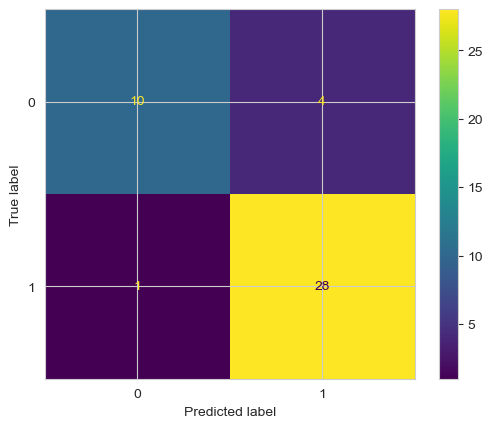

In [66]:
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

## TEST: Try different parameters (hidden layers, solvers, etc.)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.96      0.93      0.95        29

    accuracy                           0.93        43
   macro avg       0.92      0.93      0.92        43
weighted avg       0.93      0.93      0.93        43



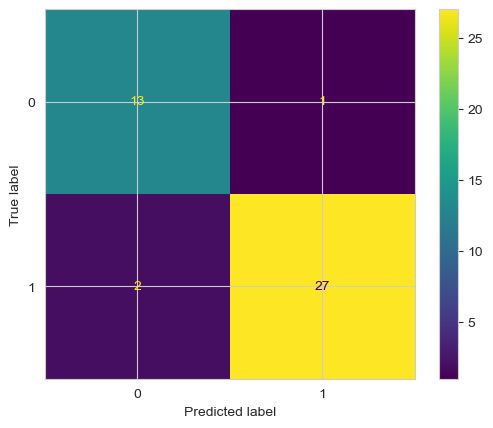

In [67]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(3,2), max_iter=4000, solver='sgd',
                         random_state=14)
mlp_model.fit(X_train,y_train)
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

##### Hidden Layers (3,2) shows .95 accuracy!!!

### MLP Regressor

In [68]:
mlpr = hist.copy()

y = hist['Close']
X = mlpr.drop(['Close'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

((200, 7), (52, 7), (200,), (52,))

### MLP Regressor Parameter search

In [69]:
# Inspired by Deniega (2023) ADS 505 Final
# Finding best estimator will take some time
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16,
                           '(2,2)', '(3,2)', '(4,2)', '(5,2)', '(3,3)', '(3,4)', '(3,5)', '(4,3)', '(4,4)',
                           '(4,5)', '(5,4)', '(5,5)', '(2,2,2)', '(2,2,3)', '(2,3,2)', '(3,2,2)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPRegressor(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')

In [70]:
# Model and fitting
mlpr_model = MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')
mlpr_model.fit(X_train,y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')

In [71]:
mlpr_pred = mlpr_model.predict(X_valid)
mlpr_pred = pd.Series(mlpr_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlpr_pred.index)
#close_valid.shape, mlpr_pred.shape
ts_eval_metrics(y_valid, mlpr_pred)

Time Series Evaluation Metrics
MSE = 2.16274185317226
MAE = 1.1281471235201332
RMSE = 1.4706263472317704
MAPE = 0.0026119780023842187
r2 = 0.9883216909561158



## Amazon Closing Stock Price Analysis and Forecasting 

In [72]:
# Download market data for Amazon:

amzn = yf.Ticker("AMZN")
#amzn.history_metadata

In [73]:
# Import Amazon stock dataset:

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-12-06 00:00:00-05:00,80.743500,85.052498,80.492500,84.959503,175788000,0.0,0.0
2018-12-07 00:00:00-05:00,85.253502,85.946503,81.273003,81.456497,151522000,0.0,0.0
2018-12-10 00:00:00-05:00,81.192001,82.899498,79.543503,82.051498,149896000,0.0,0.0
2018-12-11 00:00:00-05:00,83.900002,83.973503,80.980003,82.162003,124894000,0.0,0.0
2018-12-12 00:00:00-05:00,83.449997,85.249496,83.013496,83.177002,131960000,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-11-30 00:00:00-05:00,144.759995,146.929993,144.330002,146.089996,65814000,0.0,0.0
2023-12-01 00:00:00-05:00,146.000000,147.250000,145.550003,147.029999,39924600,0.0,0.0
2023-12-04 00:00:00-05:00,145.250000,145.350006,142.809998,144.839996,48294200,0.0,0.0
2023-12-05 00:00:00-05:00,143.550003,148.570007,143.130005,146.880005,46754800,0.0,0.0
2023-12-06 00:00:00-05:00,147.580002,147.830002,145.020004,146.165604,20149340,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.0,1259.000000
mean,126.709191,128.272413,125.038522,126.672913,7.731012e+07,0.0,0.015886
std,31.713547,31.996432,31.342793,31.628954,3.510572e+07,0.0,0.563660
min,67.300003,69.801498,65.349998,67.197998,1.762600e+07,0.0,0.000000
25%,95.033749,96.033749,93.790001,94.999249,5.382545e+07,0.0,0.000000
50%,125.309998,127.370003,124.120003,125.959999,6.690200e+07,0.0,0.000000
75%,158.343750,159.924004,156.199997,158.086998,9.063400e+07,0.0,0.000000
max,187.199997,188.654007,184.839493,186.570496,3.113460e+08,0.0,20.000000


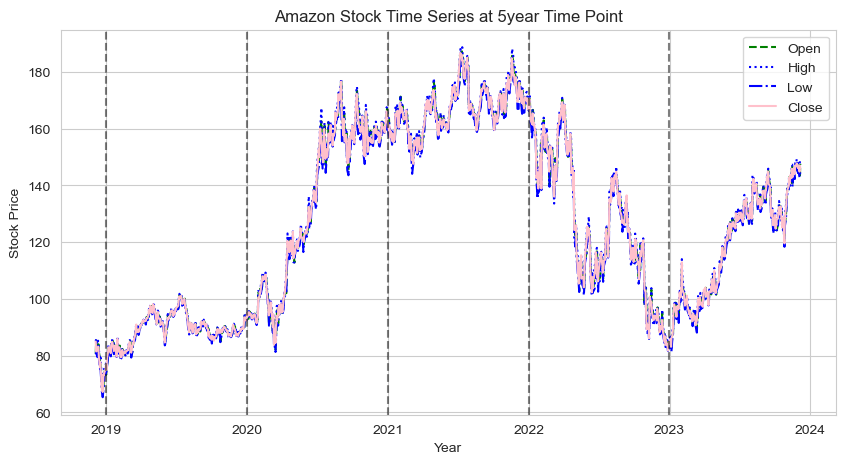

In [74]:
# Plot initial Amazon stock time series at 5y time point:

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)


plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

### Partition train and validation datasets

In [75]:
# Partition train and validation datasets:

past_year0 = amzn_df.iloc[-252:] # 252 trading days per year
b_past_year = amzn_df.iloc[:-len(past_year0)]

train = b_past_year['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.iloc[-len(past_year0):]
val_close = valid['Close'].asfreq('D')
val_close = val_close.ffill()

### Test of Stationarity Through Augmented Dickey–Fuller Method

In [76]:
# Determine dataset stationarity:
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

ADF Statistic: -1.454588
p-value: 0.555845
Critical Values:
{'1%': -3.4348399537053482, '5%': -2.8635230163107837, '10%': -2.5678257404326903}
Time series is not stationary


### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [77]:
# Fit close stock price dataset to STL:

stl = STL(amzn_df['Close'], period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

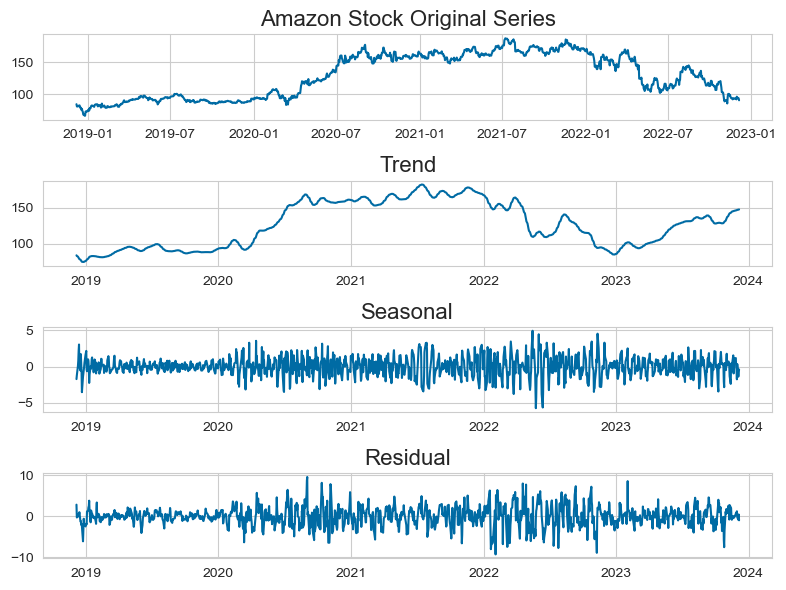

In [78]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_train)
plt.title('Amazon Stock Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt-Winters Smoothing

In [79]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

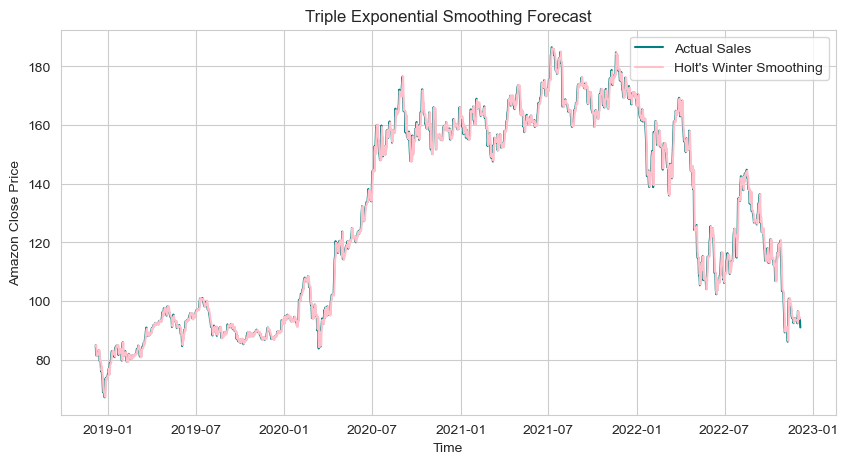

In [80]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection Using STL Decomposition

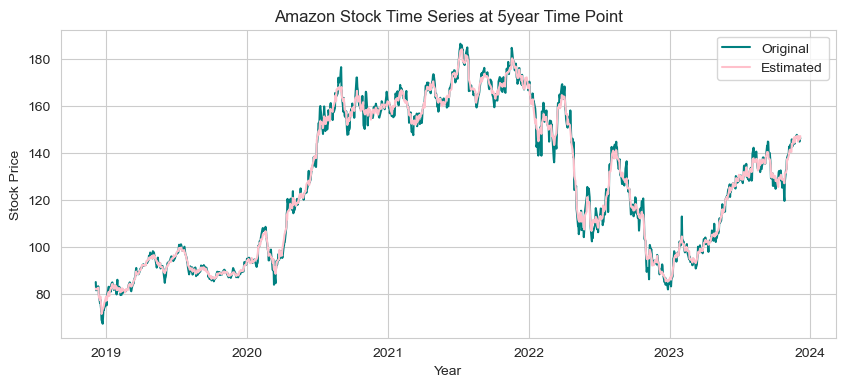

In [81]:
# Plot original Amazon Close time series vs Forecasted time series:

estimated = trend + seasonal # from STL
plt.figure(figsize=(10,4))
plt.plot(amzn_df['Close'], label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# Taking residuals and detecting anomaly at 3std. dev:

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

Text(0.5, 1.0, 'Amazon at 5year Time Point')

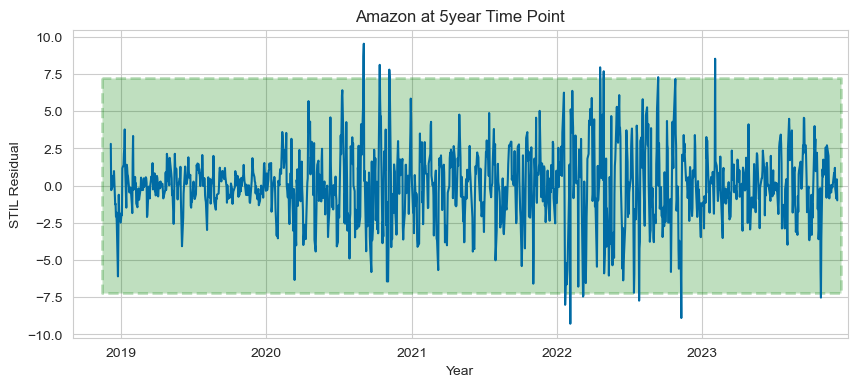

In [83]:
# Plot residual threshold:

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,15), datetime(2023,12,15)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2024,1,1))

plt.xlabel('Year')
plt.ylabel('STIL Residual')
plt.title('Amazon at 5year Time Point')

In [84]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_df['Close'][(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

Text(0.5, 1.0, 'Amazon: Anomalies Marked at 3 Std Dev or 99.7% within Normal Distribution')

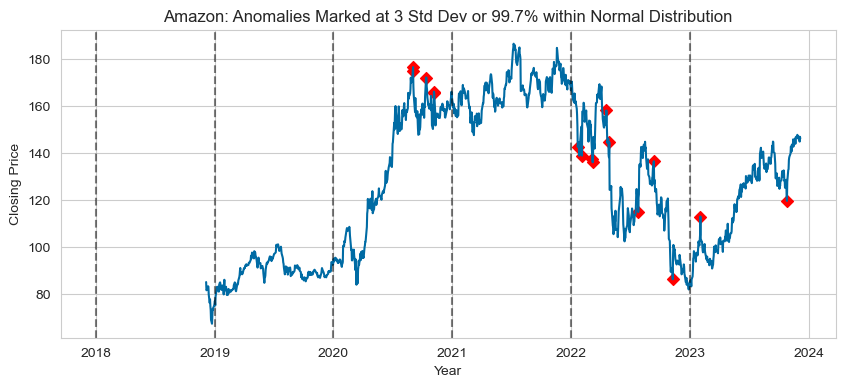

In [85]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_df['Close'])

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('Amazon: Anomalies Marked at 3 Std Dev or 99.7% within Normal Distribution')


# Plot shows anomalies detected outside of +/- 3 Std Dev of normal distribution in red. 
# Anomaly detection successful in detecting times market is most volitile.  

In [86]:
# Anomalies identified outside 3std dev of residuals:

anomalies.head()

,Close
Date,
2020-09-01 00:00:00-04:00,174.955994
2020-09-02 00:00:00-04:00,176.572495
2020-10-12 00:00:00-04:00,172.146500
2020-11-05 00:00:00-05:00,166.100006
2020-11-06 00:00:00-05:00,165.568497


### Transforming Time Series to Stationary

Text(0, 0.5, 'Amazon Stock Closing Price \n(First Diff.)')

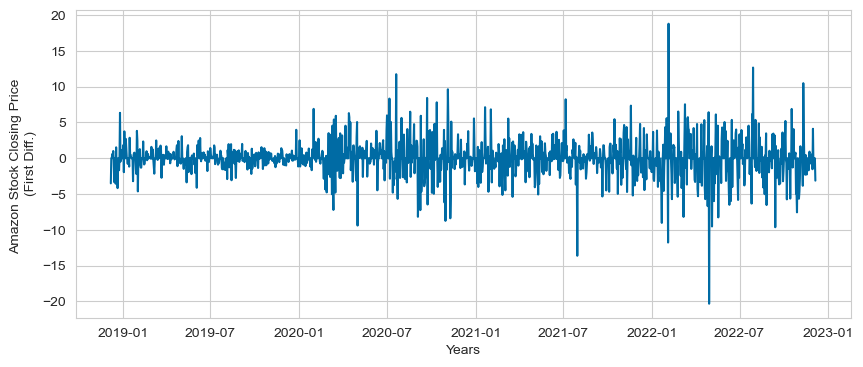

In [87]:
# Removing trend by applying the first Difference:

diff_ts = amzn_train.diff().dropna()

# Plot first difference:

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [88]:
# Determine dataset stationarity:
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

ADF Statistic: -39.915841
p-value: 0.000000
Critical Values:
{'1%': -3.4348399537053482, '5%': -2.8635230163107837, '10%': -2.5678257404326903}
Time series is stationary


### Selecting a Model

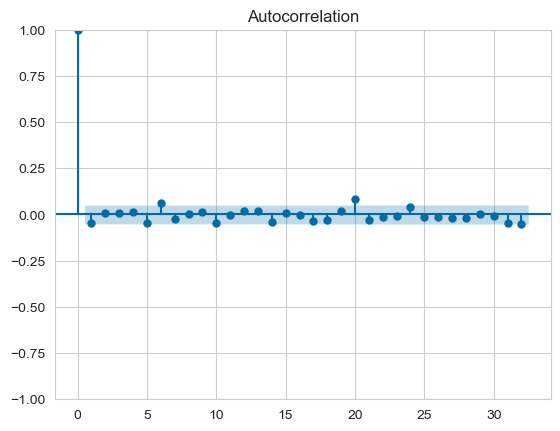

None

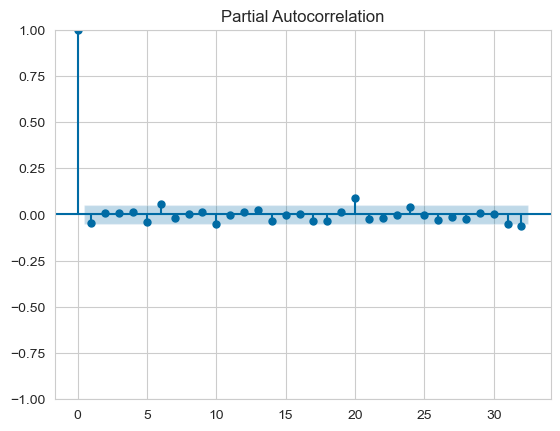

None

In [89]:
# ACF suggest MA Lag 1, 6, 10, 20, 31, 32

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1, 6, 10, 20, 31, 32

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria:

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood
>
>($k$) = a number of parameters
>
>($n$) = a number of samples used for fitting


#### Auto-ARIMA Model

In [92]:
# Auto ARIMA Model:

auto_arima_model = auto_arima(amzn_train, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

arima_pred0 = auto_arima_model.predict(n_periods=len(val_close))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6731.572, Time=9.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6736.940, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6736.043, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6736.082, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6734.944, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6739.910, Time=2.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6739.922, Time=2.81 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=9.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6735.794, Time=4.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6738.008, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6740.474, Time=1.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6741.896, Time=4.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6737.578, Time=6.39 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6728.715, Time=3.76 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [93]:
# ARIMA Model and Forecast at ARIMA(2,1,2):

# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

arima_m = sm.tsa.ARIMA(amzn_train, order=(2,1,2)).fit()
print(arima_m.summary())

arima_pred1 = arima_m.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1461
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3359.357
Date:                Wed, 06 Dec 2023   AIC                           6728.715
Time:                        09:46:33   BIC                           6755.146
Sample:                    12-06-2018   HQIC                          6738.574
                         - 12-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5489      0.016    -33.395      0.000      -0.581      -0.517
ar.L2         -0.9654      0.015    -64.486      0.000      -0.995      -0.936
ma.L1          0.5281      0.015     36.179      0.0

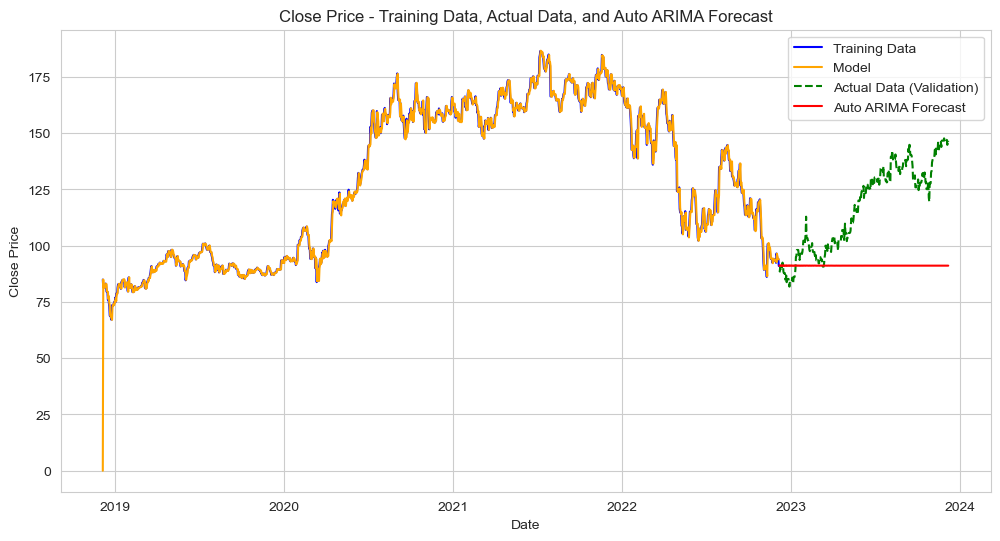

In [94]:
# Plot Auto ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(arima_m.fittedvalues, label="Model", color = 'orange')
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, arima_pred1, label='Auto ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and Auto ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Plot shows best performing ARIMA parameter at (2, 1, 2) values of p,d,q. 
# Although, the auto forecast did very poorly in predicting the validation dataset. 

#### ARIMA Model

In [95]:
# AR lag optimization:

ar_orders0 = [1, 6, 10, 20, 31, 32]
fitted_model_dict = {}

for i, ar_order0 in enumerate(ar_orders0):
    ar_model0 = sm.tsa.arima.ARIMA(amzn_train, order=(ar_order0,1,1),trend='n')
    ar_model_fit0 = ar_model0.fit()
    fitted_model_dict[ar_order0] = ar_model_fit0

for ar_order0 in ar_orders0:
    print('AIC for AR(%s): %s' %(ar_order0, fitted_model_dict[ar_order0].aic))
    print('BIC for AR(%s): %s' %(ar_order0, fitted_model_dict[ar_order0].bic))
    print('\n')

AIC for AR(1): 6736.01301504769
BIC for AR(1): 6751.871590191797


AIC for AR(6): 6737.6571623807
BIC for AR(6): 6779.946696098319


AIC for AR(10): 6741.538592569041
BIC for AR(10): 6804.972893145469


AIC for AR(20): 6742.060515746525
BIC for AR(20): 6858.356733469977


AIC for AR(31): 6752.02173626261
BIC for AR(31): 6926.466062847789


AIC for AR(32): 6749.1344001919
BIC for AR(32): 6928.86491849178




##### Result:

AR order 1 has the lowest AIC and BIC scores.

In [96]:
# MA lag optimization:

ma_orders0 = [1, 6, 10, 20, 31, 32]
fitted_model_dict = {}

for i, ma_order0 in enumerate(ma_orders0):
    ma_model0 = sm.tsa.arima.ARIMA(amzn_train, order=(1,1,ma_order0),trend='n')
    ma_model_fit0 = ma_model0.fit()
    fitted_model_dict[ma_order0] = ma_model_fit0

for ma_order0 in ma_orders0:
    print('AIC for AR(%s): %s' %(ma_order0, fitted_model_dict[ma_order0].aic))
    print('BIC for AR(%s): %s' %(ma_order0, fitted_model_dict[ma_order0].bic))
    print('\n')

AIC for AR(1): 6736.01301504769
BIC for AR(1): 6751.871590191797


AIC for AR(6): 6737.223228901863
BIC for AR(6): 6779.512762619482


AIC for AR(10): 6742.1198627922495
BIC for AR(10): 6805.554163368678


AIC for AR(20): 6740.019098032078
BIC for AR(20): 6856.31531575553


AIC for AR(31): 6751.072872935745
BIC for AR(31): 6925.517199520924


AIC for AR(32): 6750.326203857716
BIC for AR(32): 6930.056722157597




##### Result:

MA order 1 has the lowest AIC and BIC scores.

In [97]:
# ARIMA Model and Forecast at ARIMA(1,1,1):

# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

arima_m0 = sm.tsa.ARIMA(amzn_train, order=(1,1,1)).fit()
print(arima_m0.summary())

arima_pred2 = arima_m0.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3365.007
Date:                Wed, 06 Dec 2023   AIC                           6736.013
Time:                        09:49:58   BIC                           6751.872
Sample:                    12-06-2018   HQIC                          6741.929
                         - 12-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1467      0.572     -0.257      0.797      -1.267       0.974
ma.L1          0.1023      0.571      0.179      0.858      -1.017       1.222
sigma2         5.8810      0.105     55.949      0.0

In [98]:
# Statistical Metrics:

print('AIC = %s' %(arima_m0.aic))
print('BIC = %s' %(arima_m0.bic))
arima0_metrics = ts_eval_metrics(val_close, arima_pred2)

AIC = 6736.01301504769
BIC = 6751.871590191797
Time Series Evaluation Metrics
MSE = 1031.8573910424893
MAE = 26.70836967211166
RMSE = 32.12253712026012
MAPE = 0.2089289886237563
r2 = -1.8170633816928756



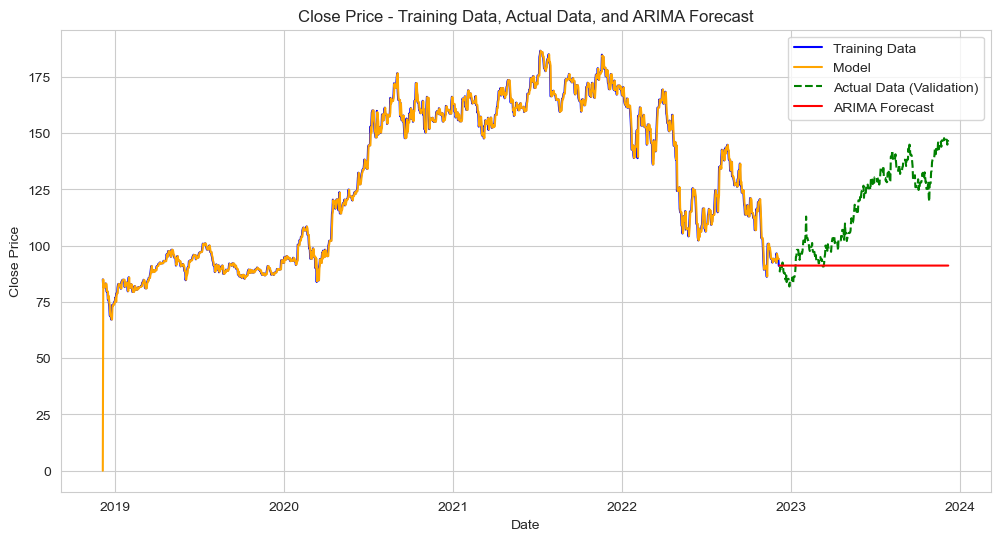

In [99]:
# Plot ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(arima_m0.fittedvalues, label="Model", color = 'orange')
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, arima_pred2, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Same with auto-ARIMA, ARIMA with (1,1,1) parameters selected through metric scores performance did very poorly. 
# Manual selection of ARIMA parameters did not predict closing prices well compared to the validation dataset. 

#### AES Model

In [100]:
# Define AES parameters for optimization:

aes_param_trend0 = ['add', 'mul', None]
aes_param_seasonal0 = ['add', 'mul', None] # set to mul by default
aes_param_initial_method0 = [None, 'estimated', 'heuristic', 'legacy-heuristic']


fitted_model_dict0 = {}

In [101]:
# Trend parameter optimization:

for i in aes_param_trend0:
    aes_model2 = ExponentialSmoothing(amzn_train,
                                     trend=i,
                                     damped_trend=False, # Error message: Can only dampen the trend component
                                     seasonal= 'mul',
                                     seasonal_periods= 252,
                                     initialization_method='heuristic'
                                    )
    aes_model2 = aes_model2.fit(
                             )

    print('Results for Trend %s' % (i))
    print('AIC = %s' %(aes_model2.aic))
    print('BIC = %s' %(aes_model2.bic))
    aes_pred2 = aes_model2.forecast(steps=len(val_close))
    aes_eval_metrics2 = ts_eval_metrics(val_close, aes_pred2)

Results for Trend add
AIC = 2935.0353837575944
BIC = 4288.475745165773
Time Series Evaluation Metrics
MSE = 688.7331779280738
MAE = 21.384358005836013
RMSE = 26.243726448964406
MAPE = 0.166243838554919
r2 = -0.8803034529199276

Results for Trend mul
AIC = 2935.9454665728076
BIC = 4289.3858279809865
Time Series Evaluation Metrics
MSE = 661.8497690173971
MAE = 20.961701342906903
RMSE = 25.726441048411594
MAPE = 0.16297816333343942
r2 = -0.8069093313341618

Results for Trend None
AIC = 2930.776586087557
BIC = 4273.643194672235
Time Series Evaluation Metrics
MSE = 1068.4557409618478
MAE = 27.040784018258496
RMSE = 32.68724125651854
MAPE = 0.2110652997195046
r2 = -1.9169801650422151



##### Result

No trend parameter has the lowest AIC and BIC scores.

In [102]:
# Initialization method optimization:

for i in aes_param_initial_method0:
    aes_model3 = ExponentialSmoothing(amzn_train,
                                     trend= None,
                                     seasonal= 'mul',
                                     seasonal_periods= 252,
                                     initialization_method=i
                                    )
    aes_model3 = aes_model3.fit(
                             )

    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model3.aic))
    print('BIC = %s' %(aes_model3.bic))
    aes_pred3 = aes_model3.forecast(steps=len(val_close))
    aes_eval_metrics3 = ts_eval_metrics(val_close, aes_pred3)

Results for Initialization Method None
AIC = 3609.620803546928
BIC = 4952.487412131606
Time Series Evaluation Metrics
MSE = 1481.1650550816153
MAE = 34.28140740972969
RMSE = 38.48590722695277
MAPE = 0.27744598894290146
r2 = -3.043713671225441

Results for Initialization Method estimated
AIC = 2769.855744569606
BIC = 4112.722353154284
Time Series Evaluation Metrics
MSE = 1265.169995101049
MAE = 30.205595138759247
RMSE = 35.569228205023634
MAPE = 0.2382686138700928
r2 = -2.4540277520471436

Results for Initialization Method heuristic
AIC = 2930.776586087557
BIC = 4273.643194672235
Time Series Evaluation Metrics
MSE = 1068.4557409618478
MAE = 27.040784018258496
RMSE = 32.68724125651854
MAPE = 0.2110652997195046
r2 = -1.9169801650422151

Results for Initialization Method legacy-heuristic
AIC = 3609.620803546928
BIC = 4952.487412131606
Time Series Evaluation Metrics
MSE = 1481.1650550816153
MAE = 34.28140740972969
RMSE = 38.48590722695277
MAPE = 0.27744598894290146
r2 = -3.043713671225441



##### Result

For initialization method, heuristic and estimated methods performed the best.

In [121]:
# Final AES Model on train dataset:

aes_modelf = ExponentialSmoothing(amzn_train,
                                 trend= None,
                                 seasonal= 'mul', # set by default, add is poor performer visually
                                 seasonal_periods= 252, #252 trading days per year forecast
                                 initialization_method='heuristic')

aes_modelf = aes_modelf.fit(smoothing_level=.5,
                              smoothing_trend=.5)


aes_predf = aes_modelf.forecast(steps=len(val_close))
aes_eval_metricsf = ts_eval_metrics(val_close, aes_predf)

print('AIC = %s' %(aes_modelf.aic))
print('BIC = %s' %(aes_modelf.bic))

Time Series Evaluation Metrics
MSE = 1013.1472411953386
MAE = 26.14977501692958
RMSE = 31.829973942737347
MAPE = 0.20371517803578465
r2 = -1.7659829916525966

AIC = 3283.5533476328433
BIC = 4626.419956217521


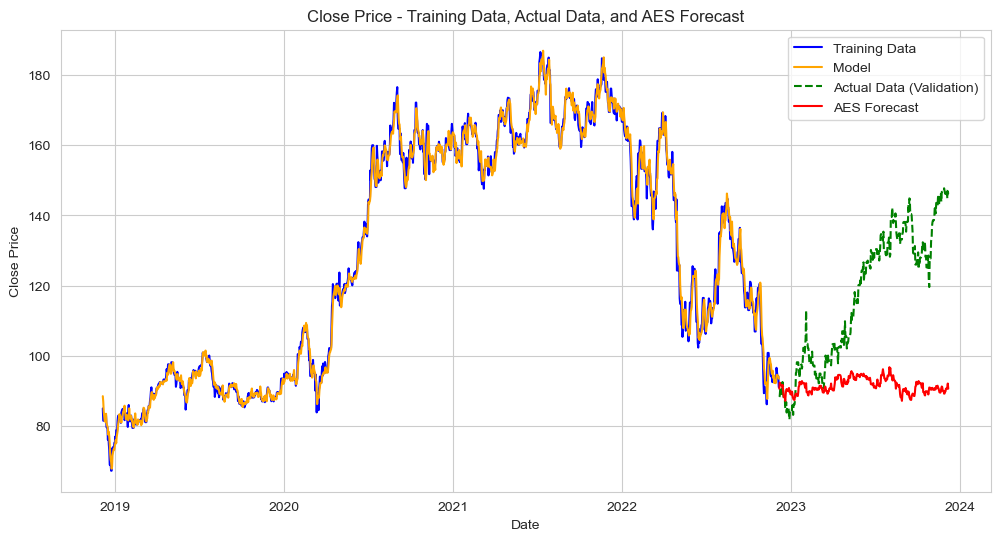

In [122]:
# Plot AES Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(aes_modelf.fittedvalues, label="Model", color = 'orange')
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, aes_predf, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()


# AES forecasting model performed better than ARIMA model. 
# But compared to the validation dataset, AES did poorly overall. 

#### Logistic Regression

In [105]:
# Pull 1 year Amazon history log:

amzn_1 = yf.Ticker("AMZN")
hist0 = amzn_1.history(period = '1y')


# Create new predictors and outcome variables:

hist0['open_close'] = hist0['Close'] - hist0['Open']
hist0['positive'] = np.where(hist0['open_close'] > 0, 1, 0)

hist0['high_low'] = hist0['High'] - hist0['Low']
hist0 = hist0.drop(['Dividends', 'Stock Splits'], axis=1)

hist0.head()

,Open,High,Low,Close,Volume,open_close,positive,high_low
Date,,,,,,,,
2022-12-06 00:00:00-05:00,90.500000,91.040001,87.900002,88.250000,75503600,-2.250000,0,3.139999
2022-12-07 00:00:00-05:00,88.339996,89.889999,87.480003,88.459999,68086900,0.120003,1,2.409996
2022-12-08 00:00:00-05:00,89.239998,90.860001,87.879997,90.349998,73305900,1.110001,1,2.980003
2022-12-09 00:00:00-05:00,88.900002,90.300003,88.629997,89.089996,67398500,0.189995,1,1.670006
2022-12-12 00:00:00-05:00,89.209999,90.580002,87.870003,90.550003,61999800,1.340004,1,2.709999


In [106]:
amzn_desc = hist0.copy()
amzn_desc['Date'] = pd.to_datetime(amzn_desc.index)
amzn_desc.insert(0, 'day_of_week', amzn_desc['Date'].dt.day_name())
amzn_desc.head()

,day_of_week,Open,High,Low,Close,Volume,open_close,positive,high_low,Date
Date,,,,,,,,,,
2022-12-06 00:00:00-05:00,Tuesday,90.500000,91.040001,87.900002,88.250000,75503600,-2.250000,0,3.139999,2022-12-06 00:00:00-05:00
2022-12-07 00:00:00-05:00,Wednesday,88.339996,89.889999,87.480003,88.459999,68086900,0.120003,1,2.409996,2022-12-07 00:00:00-05:00
2022-12-08 00:00:00-05:00,Thursday,89.239998,90.860001,87.879997,90.349998,73305900,1.110001,1,2.980003,2022-12-08 00:00:00-05:00
2022-12-09 00:00:00-05:00,Friday,88.900002,90.300003,88.629997,89.089996,67398500,0.189995,1,1.670006,2022-12-09 00:00:00-05:00
2022-12-12 00:00:00-05:00,Monday,89.209999,90.580002,87.870003,90.550003,61999800,1.340004,1,2.709999,2022-12-12 00:00:00-05:00


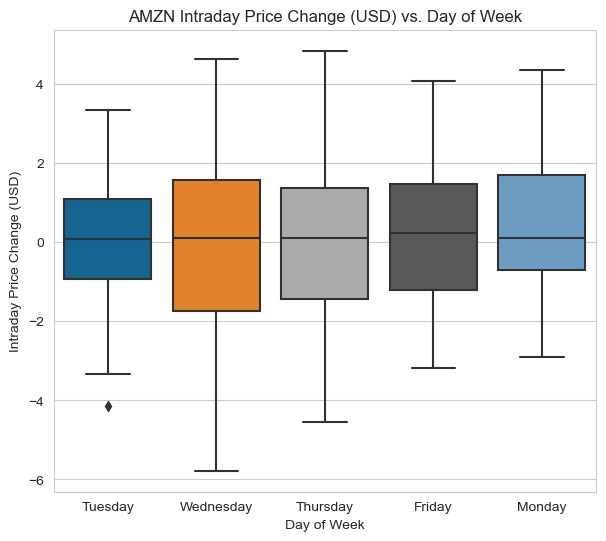

In [107]:
target_y = 'open_close'
column_x = 'day_of_week'

plt.figure(figsize=(7, 6))
sns.boxplot(x=column_x, y=target_y, data=amzn_desc)
sns.set_style("whitegrid")
plt.title("AMZN Intraday Price Change (USD) vs. Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Intraday Price Change (USD)")
plt.show()

In [108]:
day_week_stats = amzn_desc.groupby('day_of_week').describe().transpose()
display(day_week_stats.loc['open_close'])

day_of_week,Friday,Monday,Thursday,Tuesday,Wednesday
count,51.000000,45.000000,51.000000,52.000000,53.000000
mean,0.338039,0.314889,0.083725,-0.031923,-0.082829
std,1.889617,1.607839,2.072043,1.639704,2.214003
min,-3.190002,-2.899994,-4.559998,-4.139992,-5.779999
25%,-1.209995,-0.700005,-1.435001,-0.927502,-1.750000
50%,0.220001,0.110001,0.110001,0.084999,0.099991
75%,1.465004,1.690002,1.380001,1.082502,1.559998
max,4.070000,4.350006,4.839996,3.330002,4.620003


In [109]:
hist0_lag = hist0.copy()

lag = 3

hist0_lag = hist0_lag.diff(periods=lag)

for i in range(1, lag+1):
    for col in hist0_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist0_lag[lag_col_name] = hist0_lag[col].shift(i)

hist0_lag = hist0_lag.dropna()

In [110]:
pd.set_option('display.max_columns', 70)
display(hist0_lag.head())

,Open,High,Low,Close,Volume,open_close,positive,high_low,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,open_close_lag1,positive_lag1,high_low_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2,Volume_lag2,open_close_lag2,positive_lag2,high_low_lag2,Open_lag1_lag2,High_lag1_lag2,Low_lag1_lag2,Close_lag1_lag2,Volume_lag1_lag2,open_close_lag1_lag2,positive_lag1_lag2,high_low_lag1_lag2,Open_lag3,High_lag3,Low_lag3,Close_lag3,Volume_lag3,open_close_lag3,positive_lag3,high_low_lag3,Open_lag1_lag3,High_lag1_lag3,Low_lag1_lag3,Close_lag1_lag3,Volume_lag1_lag3,open_close_lag1_lag3,positive_lag1_lag3,high_low_lag1_lag3,Open_lag2_lag3,High_lag2_lag3,Low_lag2_lag3,Close_lag2_lag3,Volume_lag2_lag3,open_close_lag2_lag3,positive_lag2_lag3,high_low_lag2_lag3,Open_lag1_lag2_lag3,High_lag1_lag2_lag3,Low_lag1_lag2_lag3,Close_lag1_lag2_lag3,Volume_lag1_lag2_lag3,open_close_lag1_lag2_lag3,positive_lag1_lag2_lag3,high_low_lag1_lag2_lag3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-19 00:00:00-05:00,-4.989998,-5.830002,-5.360001,-6.660004,13233500.0,-1.670006,0.0,-0.470001,-6.960007,-6.900002,-3.789993,-4.629997,45932100.0,2.330009,0.0,-3.110008,0.680000,-0.610001,-0.400002,-2.100006,22803100.0,-2.780006,-1.0,-0.209999,3.599998,3.159996,1.240005,2.490005,2899500.0,-1.109993,-1.0,1.919991,3.599998,3.159996,1.240005,2.490005,2899500.0,-1.109993,-1.0,1.919991,5.990005,5.389999,2.639999,2.139999,26906100.0,-3.850006,-1.0,2.750000,0.870003,0.690002,0.389999,2.090004,-6087100.0,1.220001,0.0,0.300003,-1.599998,-0.739998,0.729996,0.839996,-8105100.0,2.439995,1.0,-1.469994
2022-12-20 00:00:00-05:00,-4.559998,-3.360001,-3.139999,-3.259995,-10454600.0,1.300003,0.0,-0.220001,-4.989998,-5.830002,-5.360001,-6.660004,13233500.0,-1.670006,0.0,-0.470001,-6.960007,-6.900002,-3.789993,-4.629997,45932100.0,2.330009,0.0,-3.110008,0.680000,-0.610001,-0.400002,-2.100006,22803100.0,-2.780006,-1.0,-0.209999,0.680000,-0.610001,-0.400002,-2.100006,22803100.0,-2.780006,-1.0,-0.209999,3.599998,3.159996,1.240005,2.490005,2899500.0,-1.109993,-1.0,1.919991,5.990005,5.389999,2.639999,2.139999,26906100.0,-3.850006,-1.0,2.750000,0.870003,0.690002,0.389999,2.090004,-6087100.0,1.220001,0.0,0.300003
2022-12-21 00:00:00-05:00,-2.089996,-2.119995,-1.520004,-1.090004,-86876900.0,0.999992,1.0,-0.599991,-4.559998,-3.360001,-3.139999,-3.259995,-10454600.0,1.300003,0.0,-0.220001,-4.989998,-5.830002,-5.360001,-6.660004,13233500.0,-1.670006,0.0,-0.470001,-6.960007,-6.900002,-3.789993,-4.629997,45932100.0,2.330009,0.0,-3.110008,-6.960007,-6.900002,-3.789993,-4.629997,45932100.0,2.330009,0.0,-3.110008,0.680000,-0.610001,-0.400002,-2.100006,22803100.0,-2.780006,-1.0,-0.209999,3.599998,3.159996,1.240005,2.490005,2899500.0,-1.109993,-1.0,1.919991,5.990005,5.389999,2.639999,2.139999,26906100.0,-3.850006,-1.0,2.750000
2022-12-22 00:00:00-05:00,-1.990005,-1.949997,-2.260002,-1.129997,-2100200.0,0.860008,0.0,0.310005,-2.089996,-2.119995,-1.520004,-1.090004,-86876900.0,0.999992,1.0,-0.599991,-4.559998,-3.360001,-3.139999,-3.259995,-10454600.0,1.300003,0.0,-0.220001,-4.989998,-5.830002,-5.360001,-6.660004,13233500.0,-1.670006,0.0,-0.470001,-4.989998,-5.830002,-5.360001,-6.660004,13233500.0,-1.670006,0.0,-0.470001,-6.960007,-6.900002,-3.789993,-4.629997,45932100.0,2.330009,0.0,-3.110008,0.680000,-0.610001,-0.400002,-2.100006,22803100.0,-2.780006,-1.0,-0.209999,3.599998,3.159996,1.240005,2.490005,2899500.0,-1.109993,-1.0,1.919991
2022-12-23 00:00:00-05:00,-2.080002,-0.830002,-1.400002,0.059998,-16914600.0,2.139999,1.0,0.570000,-1.990005,-1.949997,-2.260002,-1.129997,-2100200.0,0.860008,0.0,0.310005,-2.089996,-2.119995,-1.520004,-1.090004,-86876900.0,0.999992,1.0,-0.599991,-4.559998,-3.360001,-3.139999,-3.259995,-10454600.0,1.300003,0.0,-0.220001,-4.559998,-3.360001,-3.139999,-3.259995,-10454600.0,1.300003,0.0,-0.220001,-4.989998,-5.830002,-5.360001,-6.660004,13233500.0,-1.670006,0.0,-0.470001,-6.960007,-6.900002,-3.789993,-4.629997,45932100.0,2.330009,0.0,-3.110008,0.680000,-0

              precision    recall  f1-score   support

           0       0.33      0.40      0.36        15
           1       0.64      0.57      0.60        28

    accuracy                           0.51        43
   macro avg       0.49      0.49      0.48        43
weighted avg       0.53      0.51      0.52        43



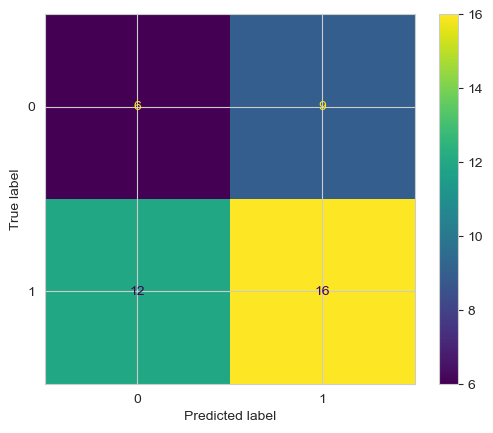

In [111]:
# Data partition for logistic regression:

y1 = hist0['positive']
X1 = hist0_lag.drop(['positive'], axis=1)
y1 = y1.reindex(X1.index)

end_train_index1 = 200
X1_train = X1.iloc[:end_train_index1]
X1_valid = X1.iloc[end_train_index1:]

y1_train = y1.iloc[:end_train_index1]
y1_valid = y1.iloc[end_train_index1:]


# Logistic regression model and fitting:

logreg_model1 = LogisticRegression()
logreg_model1.fit(X1_train,y1_train)


# Model Performance

logreg_pred1 = logreg_model1.predict(X1_valid)
logreg_pred1 = pd.Series(logreg_pred1, index=X1_valid.index)
y1_valid = y1_valid.reindex(logreg_pred1.index)

cm1 = confusion_matrix(y1_valid, logreg_pred1, labels=logreg_model1.classes_)
cmd1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=logreg_model1.classes_)
cmd1.plot()

print(classification_report(y1_valid, logreg_pred1))

#### Recurrent Neutal Network: Simple RNN and Dense  

In [1]:
#!pip install tensorflow

In [124]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam

In [125]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(amzn_train.values.reshape(-1, 1))


In [126]:
# Prepare the data for training
def create_sequences(amzn_train, seq_length):
    sequences = []
    targets = []
    for i in range(len(amzn_train) - seq_length):
        seq = amzn_train[i:i+seq_length]
        target = amzn_train[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10  # You can adjust this parameter based on your needs
X, y = create_sequences(ts_scaled, sequence_length)


In [127]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [128]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(units=1, activation='linear'))


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test)


Epoch 1/50

73/73 [==============================] - 4s 9ms/step - loss: 0.0295
Epoch 2/50
73/73 [==============================] - 1s 11ms/step - loss: 4.4529e-04
Epoch 3/50
73/73 [==============================] - 1s 10ms/step - loss: 4.4166e-04
Epoch 4/50
73/73 [==============================] - 1s 10ms/step - loss: 4.1735e-04
Epoch 5/50
73/73 [==============================] - 1s 9ms/step - loss: 3.9005e-04
Epoch 6/50
73/73 [==============================] - 1s 10ms/step - loss: 3.9663e-04
Epoch 7/50
73/73 [==============================] - 1s 8ms/step - loss: 3.7327e-04
Epoch 8/50
73/73 [==============================] - 1s 9ms/step - loss: 3.9779e-04
Epoch 9/50
73/73 [==============================] - 1s 9ms/step - loss: 3.7128e-04
Epoch 10/50
73/73 [==============================] - 1s 9ms/step - loss: 3.7273e-04
Epoch 11/50
73/73 [==============================] - 1s 10ms/step - loss: 4.1148e-04
Epoch 12/50
73/73 [==============================] - 1s 11ms/step - loss: 3.9756e-

In [129]:
# Inverse transform the predictions and actual values to the original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


# Calculate and print the metrics
aes_eval_metricsf = ts_eval_metrics(y_test_inv, y_pred_inv)

Time Series Evaluation Metrics
MSE = 11.813432471392415
MAE = 2.3807961637621475
RMSE = 3.4370674231665017
MAPE = 0.019420669767671705
r2 = 0.9718312460434593



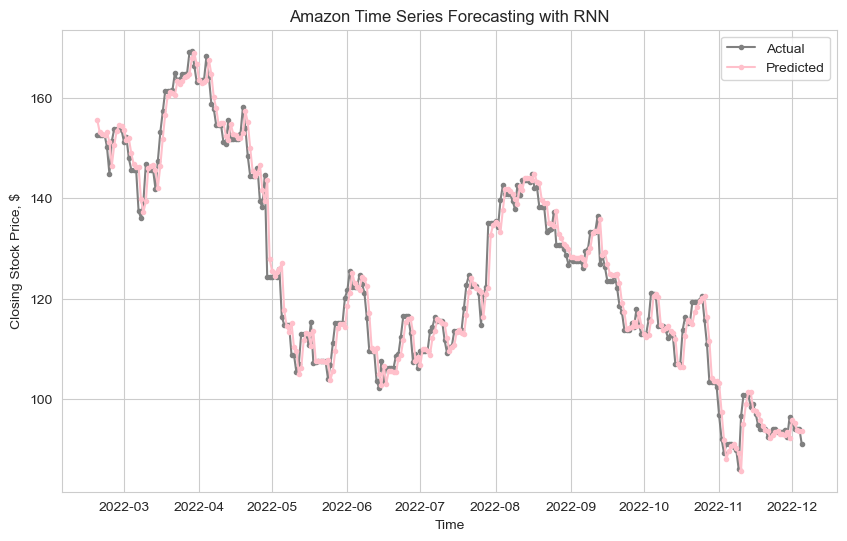

In [130]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(amzn_train.index[train_size + sequence_length:], y_test_inv, label='Actual', marker='.', color = 'gray')
plt.plot(amzn_train.index[train_size + sequence_length:], y_pred_inv, label='Predicted', marker='.', color = 'pink')
plt.title('Amazon Time Series Forecasting with RNN')
plt.xlabel('Time')
plt.ylabel('Closing Stock Price, $')
plt.legend()
plt.show()

###### Code References:
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    